# Data Science Project - Group 10

This notebook implements our Data Science project. The object of our project is to predict the price of a house based on their bedrooms, bathroom, locations and total square feet

# Problem Description

The problem under consideration involves predicting the selling or renting prices of real estate properties in Bengaluru, India, based on various features of the properties. The objective is to develop a machine learning model capable of accurately estimating the prices of houses, which can assist buyers, sellers, and real estate agents in making informed decisions about real estate transactions.


## Objective:

The primary goal is to create a predictive model that can accurately forecast the selling or renting prices of real estate properties in Bengaluru. This model will be a valuable asset for individuals and organizations involved in the real estate industry, enabling them to assess property values and make informed decisions regarding buying, selling, or renting properties in the region.


# Data Description

The dataset contains information about real estate properties in Bengaluru, India. It includes various attributes that describe different aspects of the properties. Below is a description of each attribute: 

- **area_type**: Describes the type of area of the property (e.g., Super Built-up Area, Built-up Area, Plot Area, Carpet Area).
- **availability**: Indicates the availability of the property for sale or rent (e.g., Ready To Move, Immediate Possession, Under Construction).
- **location**: Refers to the location of the property in Bengaluru, India.
- **size**: Indicates the size of the property, usually represented by the number of bedrooms.
- **society**: Represents the society or residential complex to which the property belongs.
- **total_sqft**: The total area of the property in square feet.
- **bath**: Number of bathrooms in the property.
- **balcony**: Number of balconies in the property.
- **price**: The price of the property for sale or rent in Indian Rupees (INR).

Link to dataset:
- https://www.kaggle.com/datasets/amitabhajoy/bengaluru-house-price-data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind, f_oneway, ttest_rel
from sklearn.decomposition import PCA
import umap
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, train_test_split

### Class to load data

In [2]:
class DataLoader:
    """
    Generic Class responsible for loading the dataset and splitting it into training and testing sets.

    Attributes:
        filename (str): The filename of the dataset to load.
        test_size (float): The proportion of the dataset to include in the test split.
        random_state (int or None): The seed used by the random number generator for reproducibility.

    Attributes (after loading the data):
        data_train (DataFrame): The training data features.
        labels_train (Series): The training data labels.
        data_test (DataFrame): The testing data features.
        labels_test (Series): The testing data labels.

    Methods:
        _load_data(): Loads the dataset, splits it into training and testing sets,
                      and assigns the data and labels to the appropriate attributes.
    """

    def __init__(self, filename, test_size=0.2, random_state=None):
        """
        Initializes the DataLoader with the filename of the dataset, 
        the proportion of data to include in the test split, 
        and the random state for reproducibility.
        """
        self.filename = filename
        self.test_size = test_size
        self.random_state = random_state
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

        # Load data
        self._load_data()

    def _load_data(self):
        """
        Loads the dataset from the specified filename, 
        splits it into training and testing sets using train_test_split(),
        and assigns the data and labels to the appropriate attributes.
        """
        try:
            # Load the dataset
            df = pd.read_csv(self.filename)
            
            # Split the data into features and labels
            X = df
            y = df['price']
            
            # Split the data into training and testing sets
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)
            
            # Assign the data and labels to attributes
            self.data_train = X_train
            self.labels_train = y_train
            self.data_test = X_test
            self.labels_test = y_test
            
            print("Data loaded successfully.")
            
        except FileNotFoundError:
            print("File not found. Please check the file path.")

In [3]:
data_loader = DataLoader("bengaluru_house_prices.csv")

# Access the data and labels attributes
print("Training data shape:", data_loader.data_train.shape)
print("Training labels shape:", data_loader.labels_train.shape)
print("Testing data shape:", data_loader.data_test.shape)
print("Testing labels shape:", data_loader.labels_test.shape)

Data loaded successfully.
Training data shape: (10656, 9)
Training labels shape: (10656,)
Testing data shape: (2664, 9)
Testing labels shape: (2664,)


### Class to clean the data

In [4]:
class CleanData:
    """
    A class to clean and pre-process the data
    """

    def __init__(self, data_loader):
        """
        Initializes the CleanData object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove unnecessary columns from both data_train and data_test
        self.data_train = self.data_train.drop(columns=['area_type', 'society', 'availability'])
        self.data_test = self.data_test.drop(columns=['area_type', 'society', 'availability'])
        
        # Simplify 'size' column to create 'rooms' column for both train and test data
        self.data_train['rooms'] = self.data_train['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else x)
        self.data_train.drop(columns=['size'], inplace=True)
        
        self.data_test['rooms'] = self.data_test['size'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) else x)
        self.data_test.drop(columns=['size'], inplace=True)
        
        # Convert 'total_sqft' values to single values
        self.data_train['total_sqft'] = self.data_train['total_sqft'].apply(self._convert_values)
        self.data_test['total_sqft'] = self.data_test['total_sqft'].apply(self._convert_values)
        
        # Drop rows with NaN values
        self.data_train.dropna(inplace=True)
        self.data_test.dropna(inplace=True)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]

    def _convert_values(self, x):
        '''
        Converts values in 'total_sqft' column to single values

        :param x: Value in 'total_sqft' column
        :return: Converted value
        '''
        tokens = x.split('-')
        if len(tokens) == 2:
            return (float(tokens[0]) + float(tokens[1])) / 2
        else:
            if 'Sq. Meter' in x:
                numeric_part = x.split('Sq. Meter')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqm_value = float(numeric_value)
                    sqft_value = sqm_value * 10.7639
                    return sqft_value
            elif 'Sq. Yards' in x:
                numeric_part = x.split('Sq. Yards')[0].strip()
                numeric_value = ''.join(filter(lambda char: char.isdigit() or char == '.', numeric_part))
                if numeric_value:
                    sqy_value = float(numeric_value)
                    sqft_value = sqy_value * 9
                    return sqft_value
            else:
                try:
                    return pd.to_numeric(x)
                except ValueError:
                    return None

In [5]:
clean_data = CleanData(data_loader)
clean_data.clean_data()

# Access the data and labels attributes
print("Training data shape:", clean_data.data_train.shape)
print("Training labels shape:", clean_data.labels_train.shape)
print("Testing data shape:", clean_data.data_test.shape)
print("Testing labels shape:", clean_data.labels_test.shape)

Training data shape: (10155, 6)
Training labels shape: (10155,)
Testing data shape: (2542, 6)
Testing labels shape: (2542,)


### Class to clean based on locations

In [6]:
class FilterLocations:
    """
    A class to filter the data based on locations
    """

    def __init__(self, data_loader):
        """
        Initializes the FilterLocations object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        
        # Filter locations with less than 10 rows of data
        self.data_train = self._filter_locations(self.data_train)
        self.data_test = self._filter_locations(self.data_test)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]
        
        
    def _filter_locations(self, df):
        '''
        Filters locations with less than 10 rows of data

        :param df: DataFrame containing the data
        :return: DataFrame with filtered locations
        '''
        location_counts = df.groupby('location').size()
        valid_locations = location_counts[location_counts >= 10].index.tolist()
        return df[df['location'].isin(valid_locations)]

In [7]:
filter_locations = FilterLocations(clean_data)
filter_locations.clean_data()

# Access the data and labels attributes
print("Training data shape:", filter_locations.data_train.shape)
print("Training labels shape:", filter_locations.labels_train.shape)
print("Testing data shape:", filter_locations.data_test.shape)
print("Testing labels shape:", filter_locations.labels_test.shape)

Training data shape: (7718, 6)
Training labels shape: (7718,)
Testing data shape: (1239, 6)
Testing labels shape: (1239,)


### Class to remove outliers based on Price per Square Feat

In [8]:
class RemovePriceBySquareFeatOutliers:
    """
    A class to remove the outliers based on price per square feat
    """

    def __init__(self, data_loader):
        """
        Initializes the RemovePriceBySquareFeatOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None

    def clean_data(self):
        """
        Cleans the data
        :return: Cleaned Dataset
        """
        
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Calculate price per sqft
        self.data_train['price_per_sqft'] = self.data_train['price'] / self.data_train['total_sqft']
        
        # Remove outliers
        self.data_train = self._remove_outliers(self.data_train)
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]
        
    def _remove_outliers(self, df):
        '''
        Removes outliers from the dataset

        :param df: DataFrame containing the data
        :return: DataFrame with outliers removed
        '''
        # Assuming outlier removal based on sqft per bedroom
        return df[~(df['total_sqft'] / df['rooms'] < 300)]  

In [9]:
removePriceBySquareFeat = RemovePriceBySquareFeatOutliers(filter_locations)
removePriceBySquareFeat.clean_data()

# Access the data and labels attributes
print("Training data shape:", removePriceBySquareFeat.data_train.shape)
print("Training labels shape:", removePriceBySquareFeat.labels_train.shape)
print("Testing data shape:", removePriceBySquareFeat.data_test.shape)
print("Testing labels shape:", removePriceBySquareFeat.labels_test.shape)

Training data shape: (7439, 7)
Training labels shape: (7439,)
Testing data shape: (1239, 6)
Testing labels shape: (1239,)


C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_2008\1082394269.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_train['price_per_sqft'] = self.data_train['price'] / self.data_train['total_sqft']


### Class to remove outliers based on Locations Price

In [10]:
class RemovePriceLocationsOutliers:
    """
    A class to remove outliers based on location using mean and one standard deviation
    """

    def __init__(self, data_loader):
        """
        Initializes the RemoveLocationBasedOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove outliers based on location
        self._remove_prices_outliers()
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]
        
    def _remove_prices_outliers(self):
        '''
        Remove outliers per location using mean and one standard deviation
        '''
        for key, subdf in self.data_train.groupby('location'):
            m = np.mean(subdf.price_per_sqft)
            st = np.std(subdf.price_per_sqft)
            self.data_train = self.data_train.drop(subdf[(subdf.price_per_sqft < (m - st)) | (subdf.price_per_sqft > (m + st))].index)

In [11]:
removePriceLocation = RemovePriceLocationsOutliers(removePriceBySquareFeat)
removePriceLocation.clean_data()

# Access the data and labels attributes
print("Training data shape:", removePriceLocation.data_train.shape)
print("Training labels shape:", removePriceLocation.labels_train.shape)
print("Testing data shape:", removePriceLocation.data_test.shape)
print("Testing labels shape:", removePriceLocation.labels_test.shape)

Training data shape: (5879, 7)
Training labels shape: (5879,)
Testing data shape: (1239, 6)
Testing labels shape: (1239,)


### Class to remove outliers based on Bedrooms

In [12]:
class RemoveBedroomsOutliers:
    """
    A class to remove outliers based on bedrooms using mean and one standard deviation
    """

    def __init__(self, data_loader):
        """
        Initializes the RemoveBedroomsOutliers object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def clean_data(self):
        """
        Cleans the data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Remove outliers based on bedrooms
        self._remove_bedroom_outliers()
        
        # Apply to labels
        self.labels_train = self.labels_train.loc[self.data_train.index]
        self.labels_test = self.labels_test.loc[self.data_test.index]
        
    def _remove_bedroom_outliers(self):
        '''
        Removes more outliers based on the price and the number of bedrooms
        We remove the data where 2 bedrooms apartments whose price_per_sqft is less than mean of 1 bedroom apartment
        '''
        exclude_indices = np.array([])
        for location, location_df in self.data_train.groupby('location'):
            room_stats = {}
            for room, room_df in location_df.groupby('rooms'):
                room_stats[room] = {
                    'mean': np.mean(room_df.price_per_sqft),
                    'std': np.std(room_df.price_per_sqft),
                    'count': room_df.shape[0]
                }
            for room, room_df in location_df.groupby('rooms'):
                stats = room_stats.get(room - 1)
                if stats and stats['count'] > 5:
                    exclude_indices = np.append(exclude_indices,
                                                room_df[room_df.price_per_sqft < (stats['mean'])].index.values)
        self.data_train = self.data_train.drop(exclude_indices, axis='index')

In [13]:
removeBedroom = RemoveBedroomsOutliers(removePriceLocation)
removeBedroom.clean_data()

# Access the data and labels attributes
print("Training data shape:", removeBedroom.data_train.shape)
print("Training labels shape:", removeBedroom.labels_train.shape)
print("Testing data shape:", removeBedroom.data_test.shape)
print("Testing labels shape:", removeBedroom.labels_test.shape)

Training data shape: (4598, 7)
Training labels shape: (4598,)
Testing data shape: (1239, 6)
Testing labels shape: (1239,)


### Class to visualize data

In [14]:
class VisualizeData:
    '''
    A class to visualize the data of the DataFrame
    '''

    def plot_scatter_chart(self, df, location):
        '''
        Shows the scatter plot of a certain locations based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        matplotlib.rcParams['figure.figsize'] = (15, 10)
        plt.scatter(room2['total_sqft'], room2['price'], color='blue', label='2 Rooms', s=50)
        plt.scatter(room3['total_sqft'], room3['price'], marker='p', color='red', label='3 Rooms', s=50)
        plt.xlabel("Total Square Feet Area")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(location)
        plt.legend()
        plt.show()
        
    def plot_boxplot(self, df, location):
        '''
        Shows the boxplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.boxplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Boxplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()
        
    def plot_violinplot(self, df, location):
        '''
        Shows the violinplot of a certain location based on their 2 and 3 bedrooms data
        :param df: DataFrame containing all the data
        :param location: Specific location in the DataFrame
        '''
        room2 = df[(df['location'] == location) & (df['rooms'] == 2)]
        room3 = df[(df['location'] == location) & (df['rooms'] == 3)]
        plt.figure(figsize=(15, 10))
        sns.violinplot(x='rooms', y='price', data=pd.concat([room2, room3]), hue='rooms')
        plt.xlabel("Number of Rooms")
        plt.ylabel("Price (Lakh Indian Rupees)")
        plt.title(f'Violinplot for {location}')
        plt.legend(title='Number of Rooms')
        plt.show()

    def plot_histogram(self, df, column, location):
        '''
        Shows the histogram of a certain column in the DataFrame for a specific location
        :param df: DataFrame containing all the data
        :param column: Specific column in the DataFrame
        :param location: Specific location in the DataFrame
        '''
        plt.figure(figsize=(8, 6))
        sns.histplot(df[df['location'] == location][column], kde=True)
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.title(f'Histogram of {column} in {location}')
        plt.show()
        
    def plot_heatmap(self, df):
        '''
        Shows the heatmap of correlation between columns in the DataFrame
        :param df: DataFrame containing all the data
        '''
        if 'location' in df.columns:
            df = df.drop(columns=['location'])
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap")
        plt.show()

In [15]:
# Initialize the VisualizeData object
vd = VisualizeData()

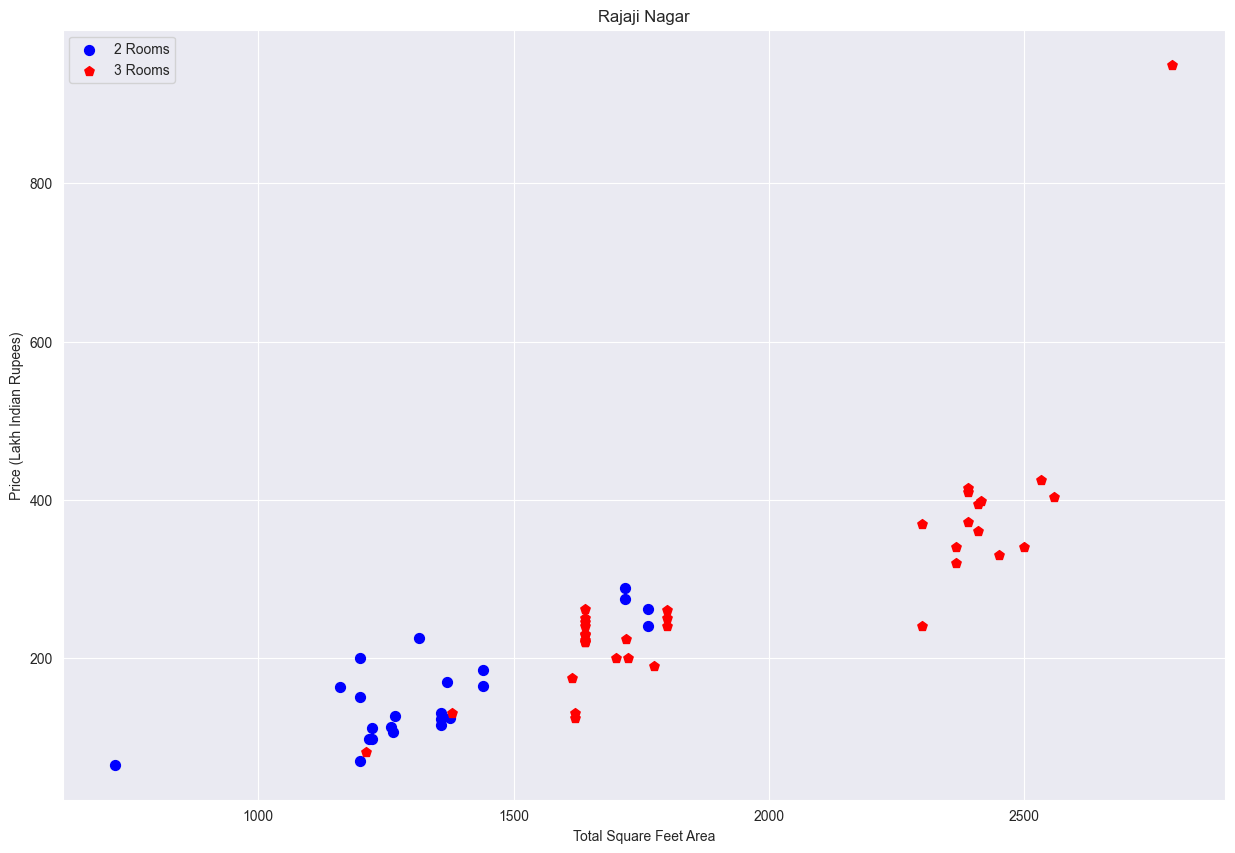

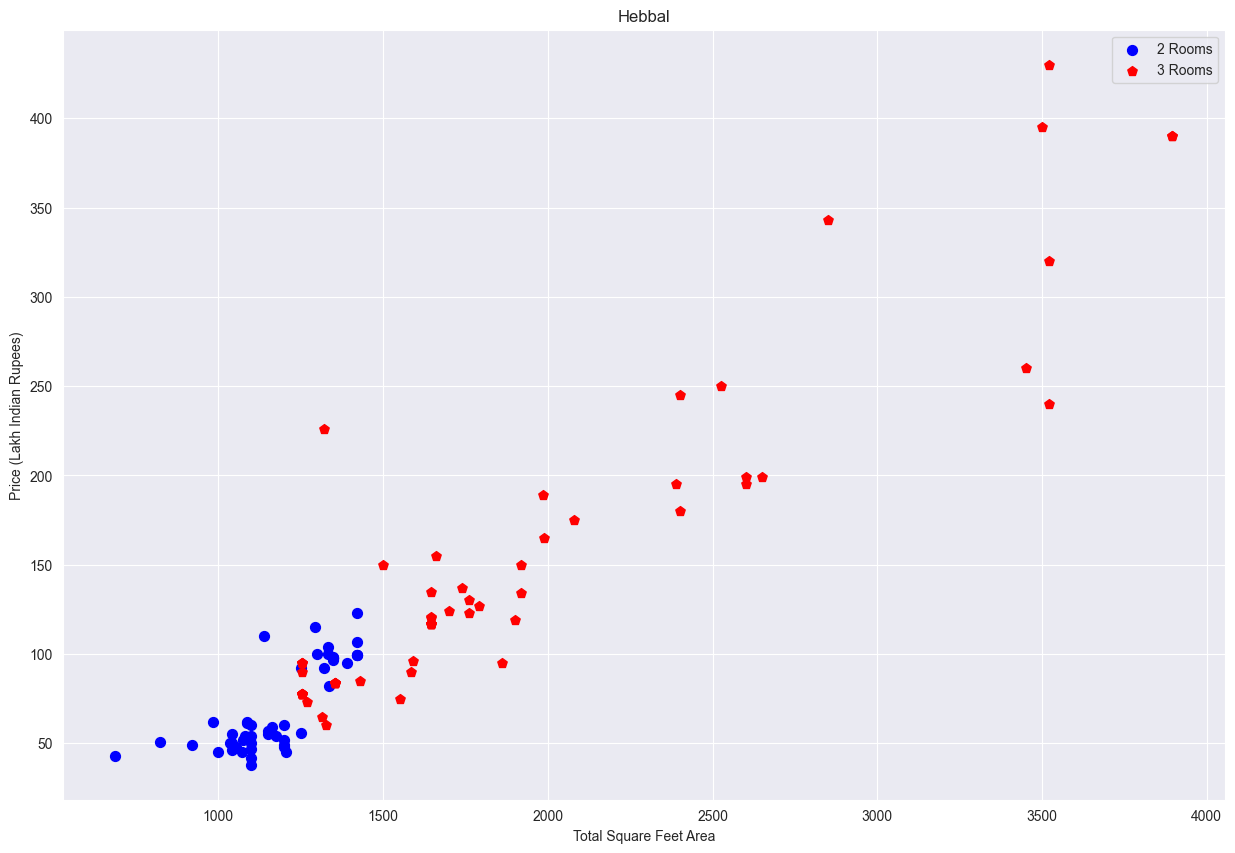

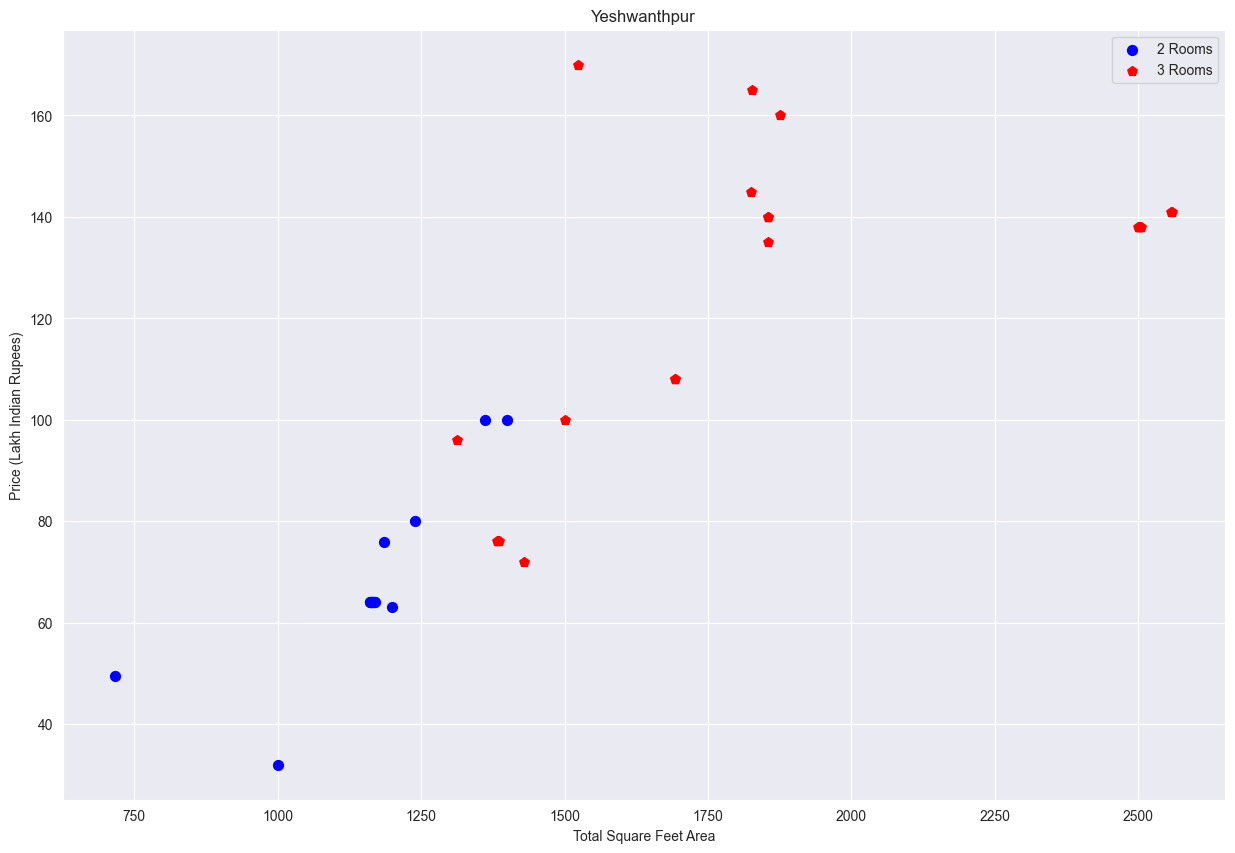

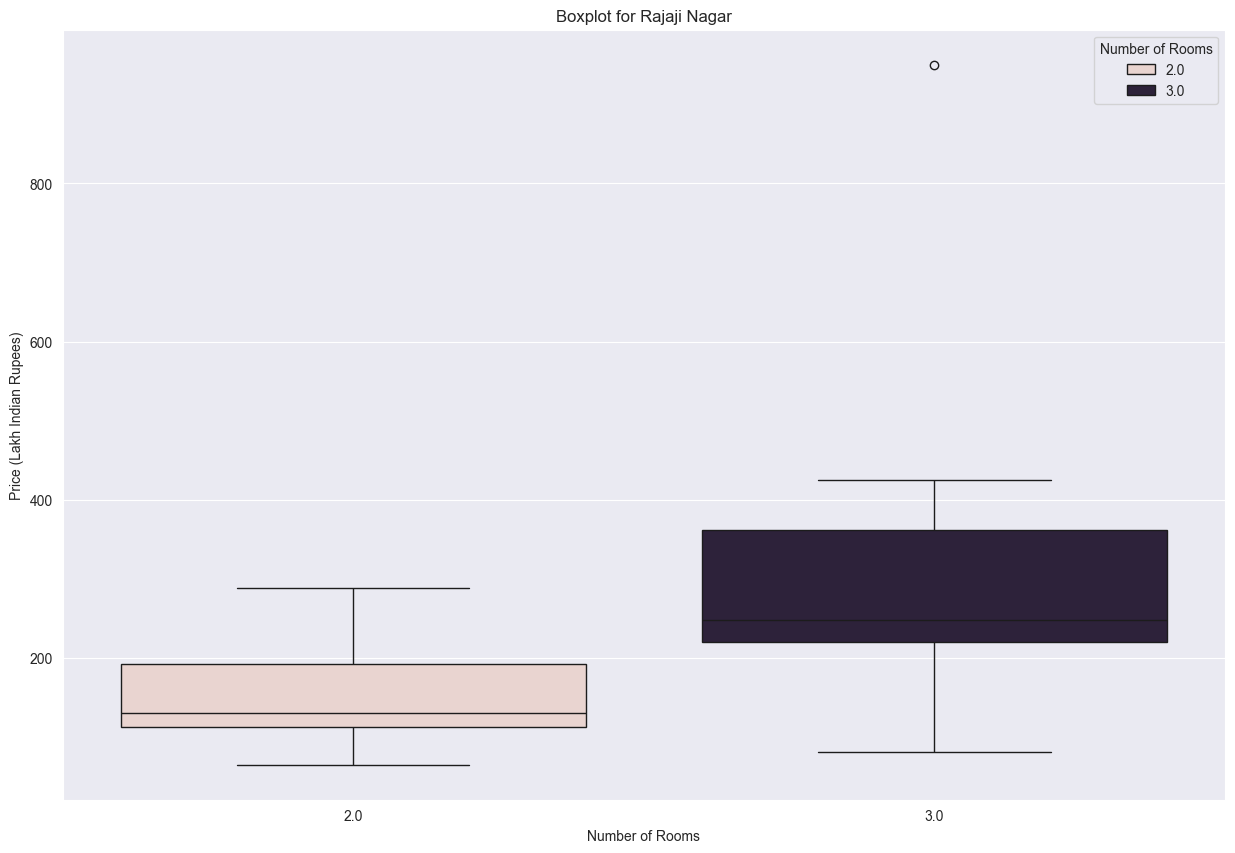

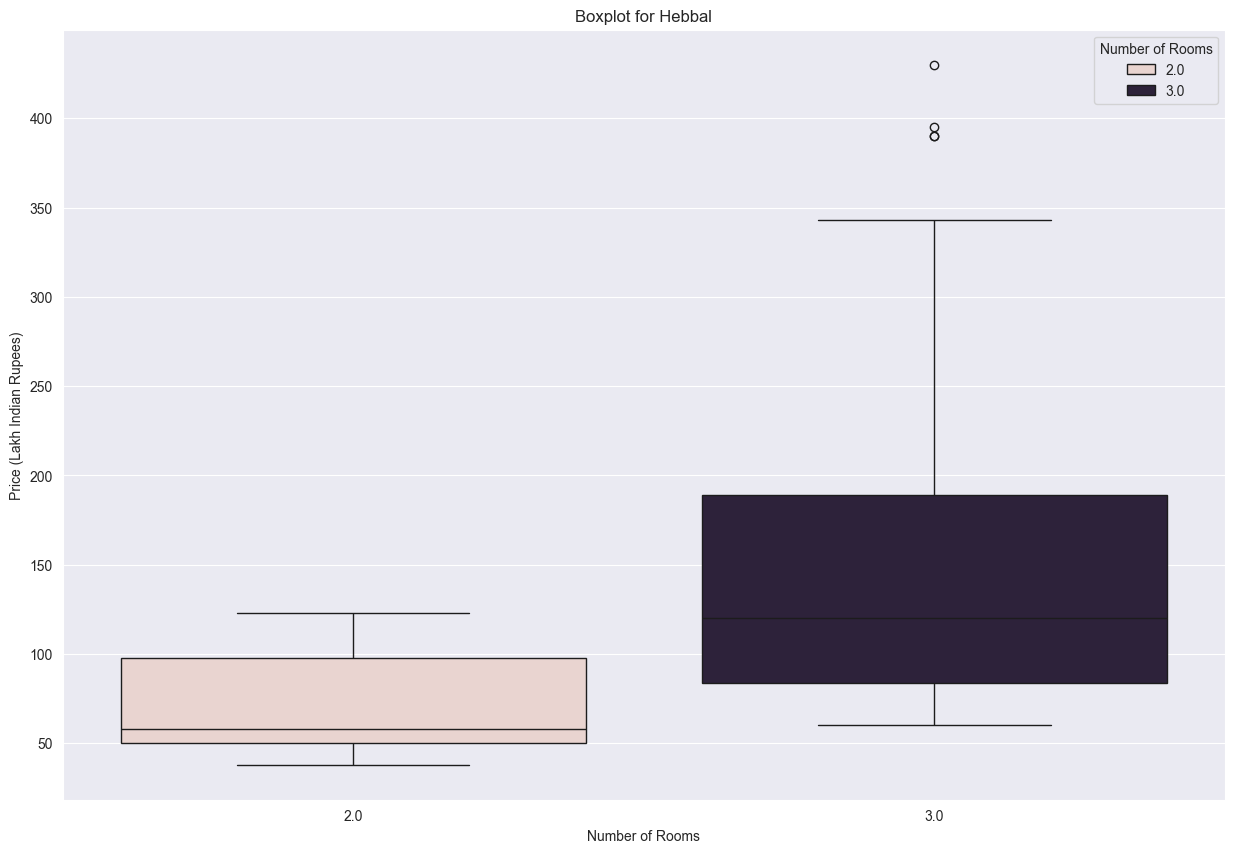

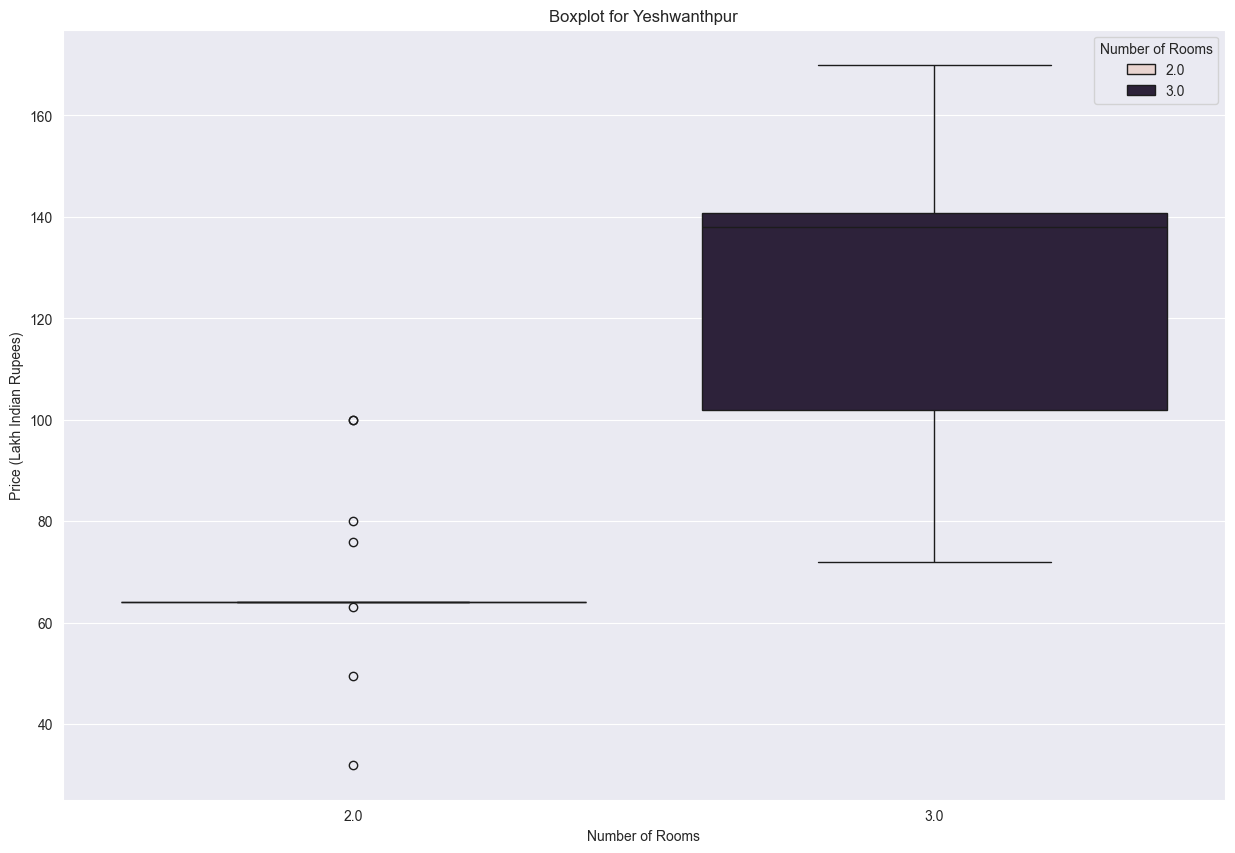

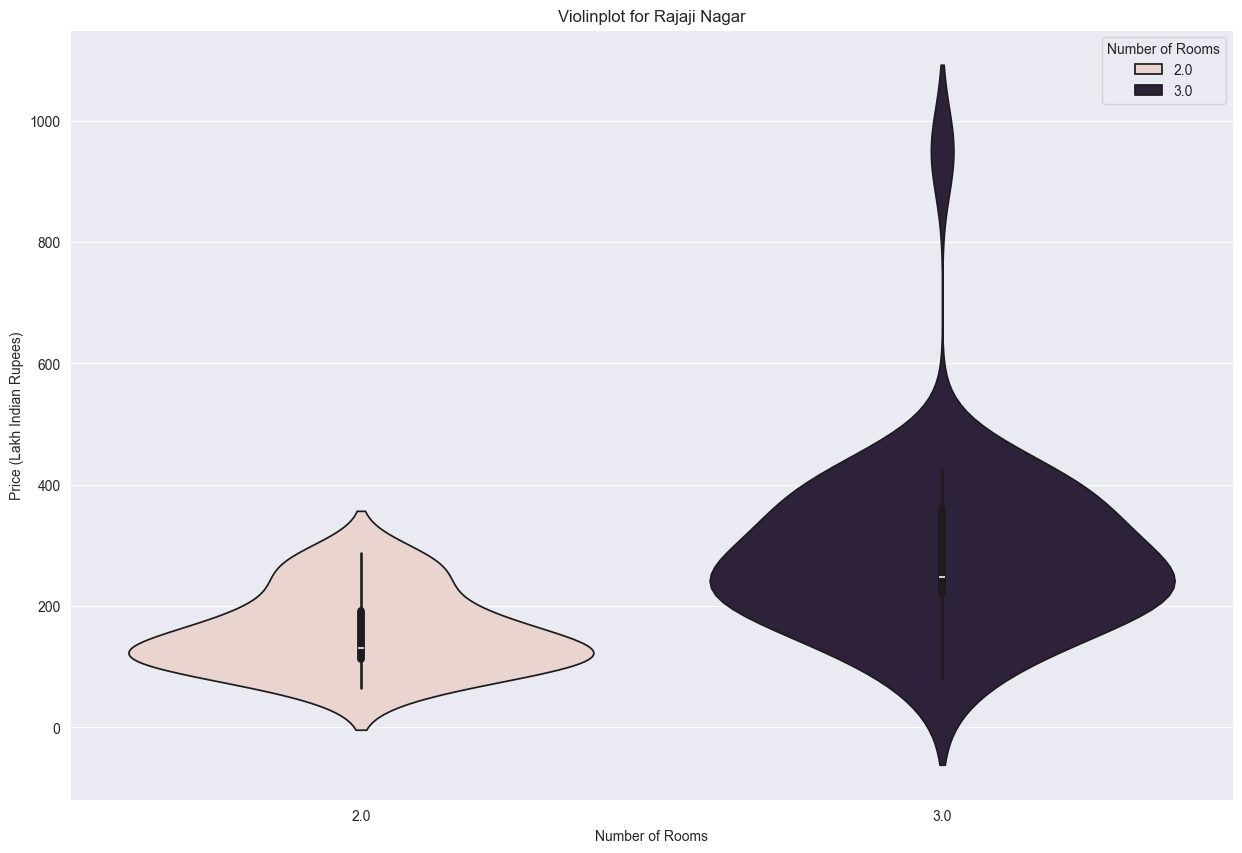

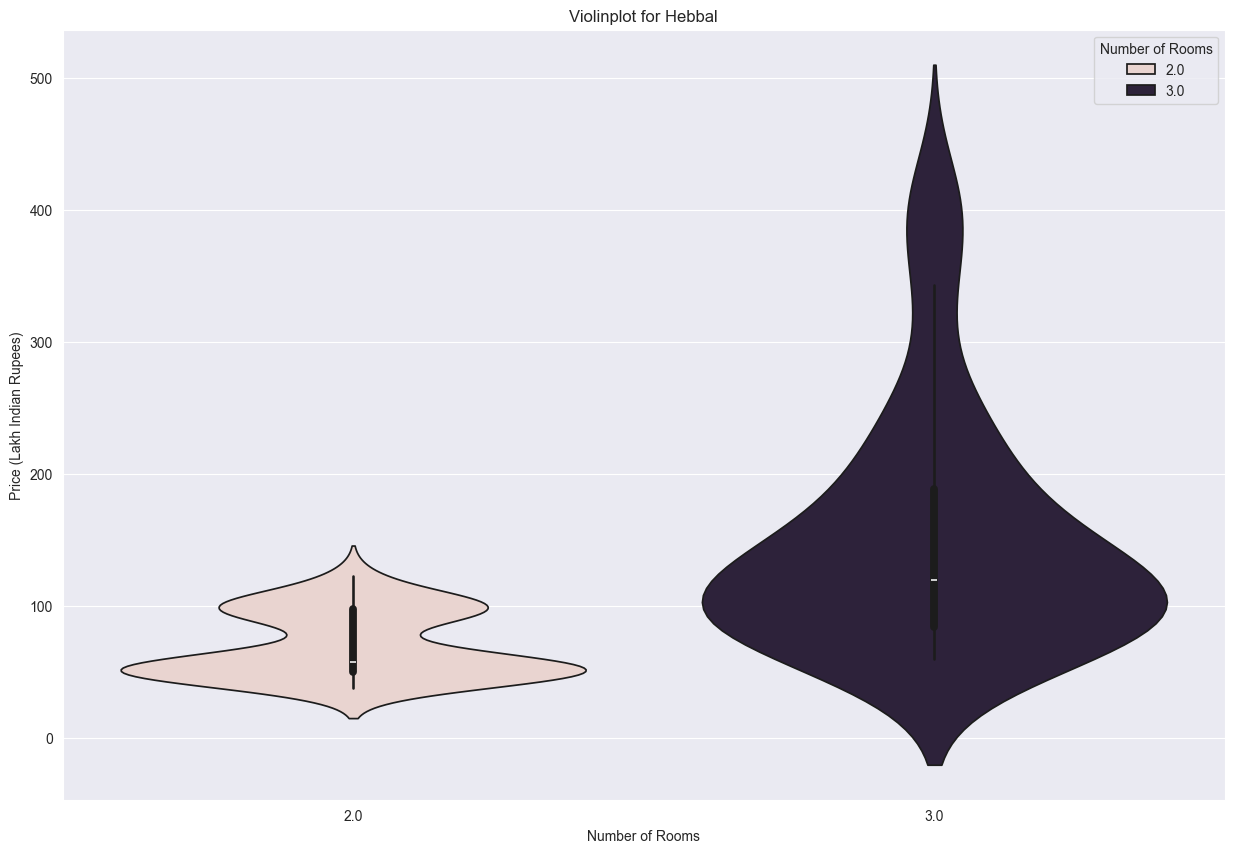

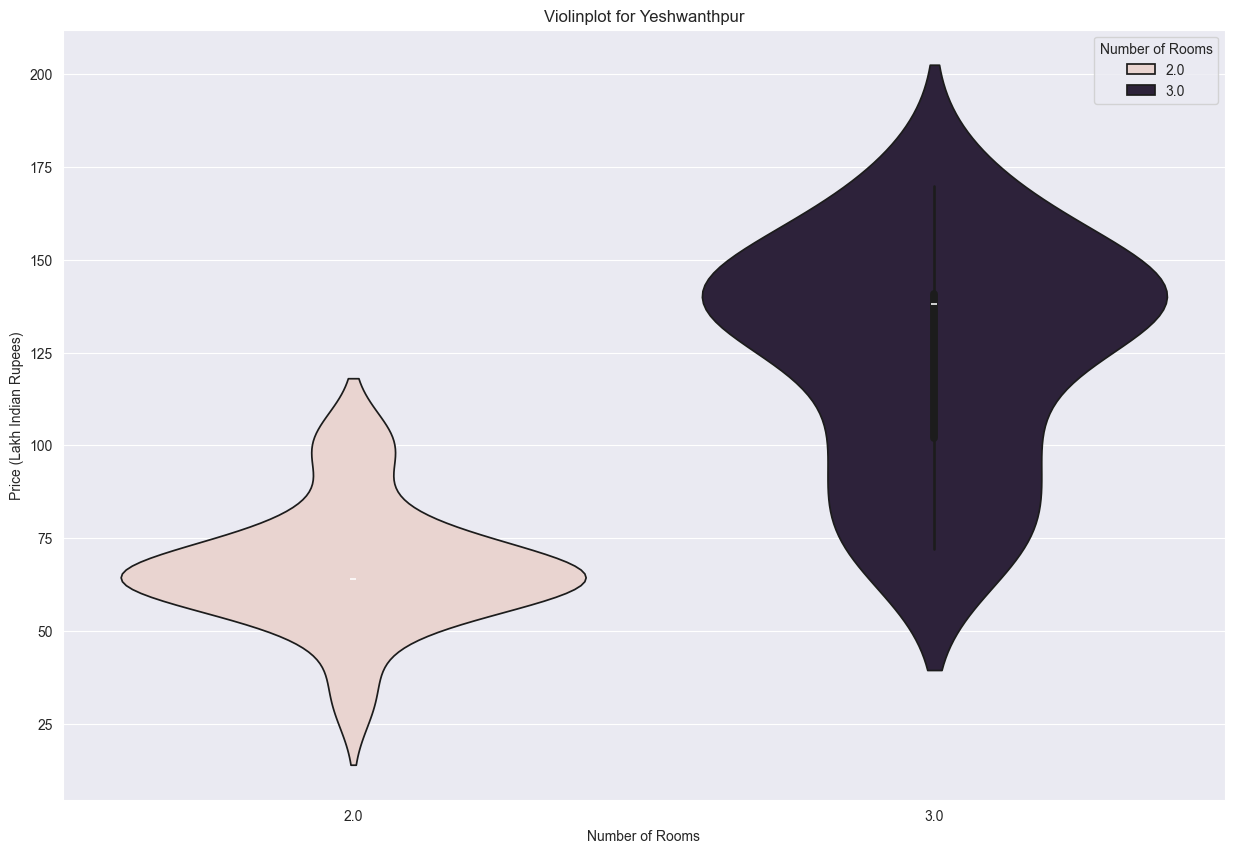

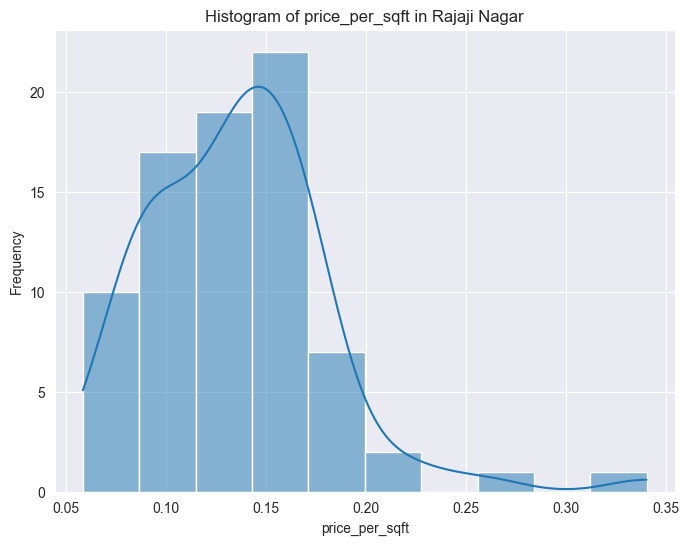

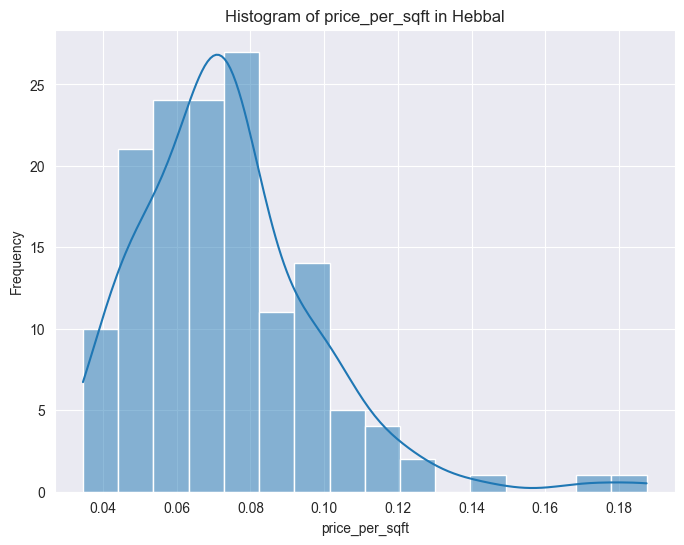

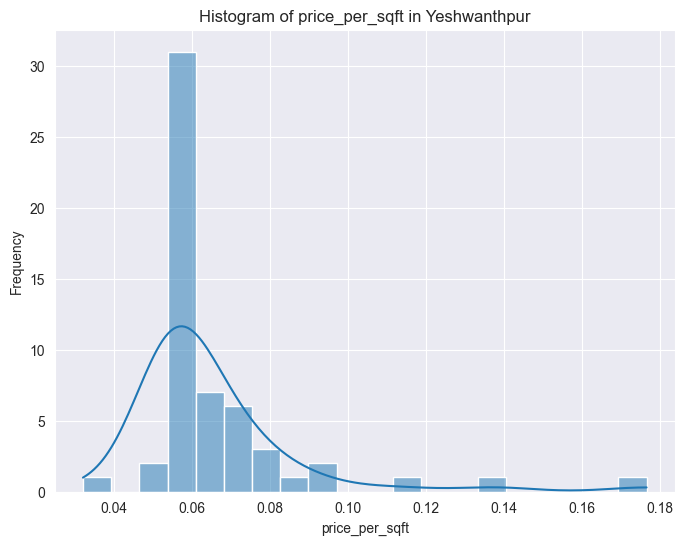

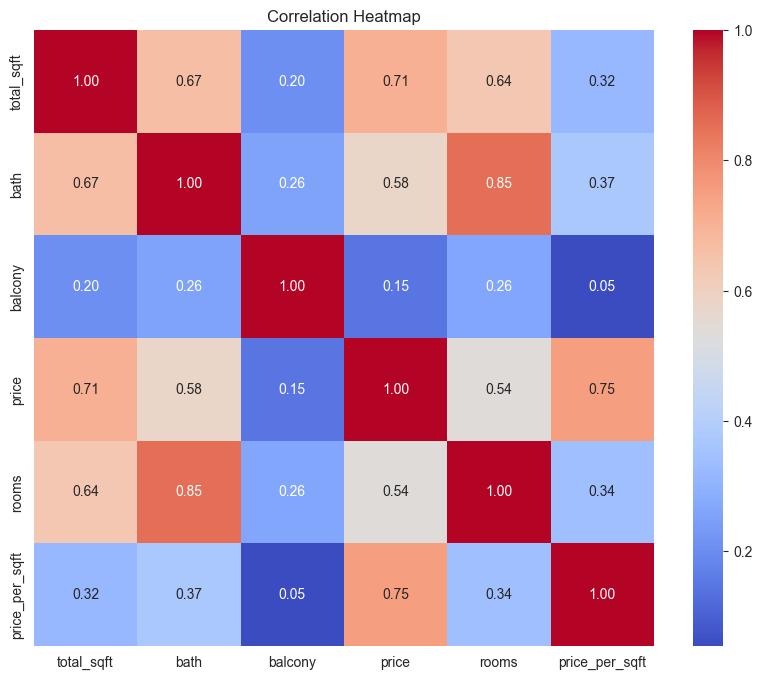

In [16]:
# Show data before outliers in scatter chart
vd.plot_scatter_chart(removePriceBySquareFeat.data_train, "Rajaji Nagar")
vd.plot_scatter_chart(removePriceBySquareFeat.data_train, "Hebbal")
vd.plot_scatter_chart(removePriceBySquareFeat.data_train, "Yeshwanthpur")

# Show data before outliers in box plots
vd.plot_boxplot(removePriceBySquareFeat.data_train, "Rajaji Nagar")
vd.plot_boxplot(removePriceBySquareFeat.data_train, "Hebbal")
vd.plot_boxplot(removePriceBySquareFeat.data_train, "Yeshwanthpur")

# Show data before outliers in violins plot
vd.plot_violinplot(removePriceBySquareFeat.data_train, "Rajaji Nagar")
vd.plot_violinplot(removePriceBySquareFeat.data_train, "Hebbal")
vd.plot_violinplot(removePriceBySquareFeat.data_train, "Yeshwanthpur")

# Show data before outliers in histograms
vd.plot_histogram(removePriceBySquareFeat.data_train, "price_per_sqft", "Rajaji Nagar")
vd.plot_histogram(removePriceBySquareFeat.data_train, "price_per_sqft", "Hebbal")
vd.plot_histogram(removePriceBySquareFeat.data_train, "price_per_sqft", "Yeshwanthpur")

# Show heatmap with correlations
vd.plot_heatmap(removePriceBySquareFeat.data_train)

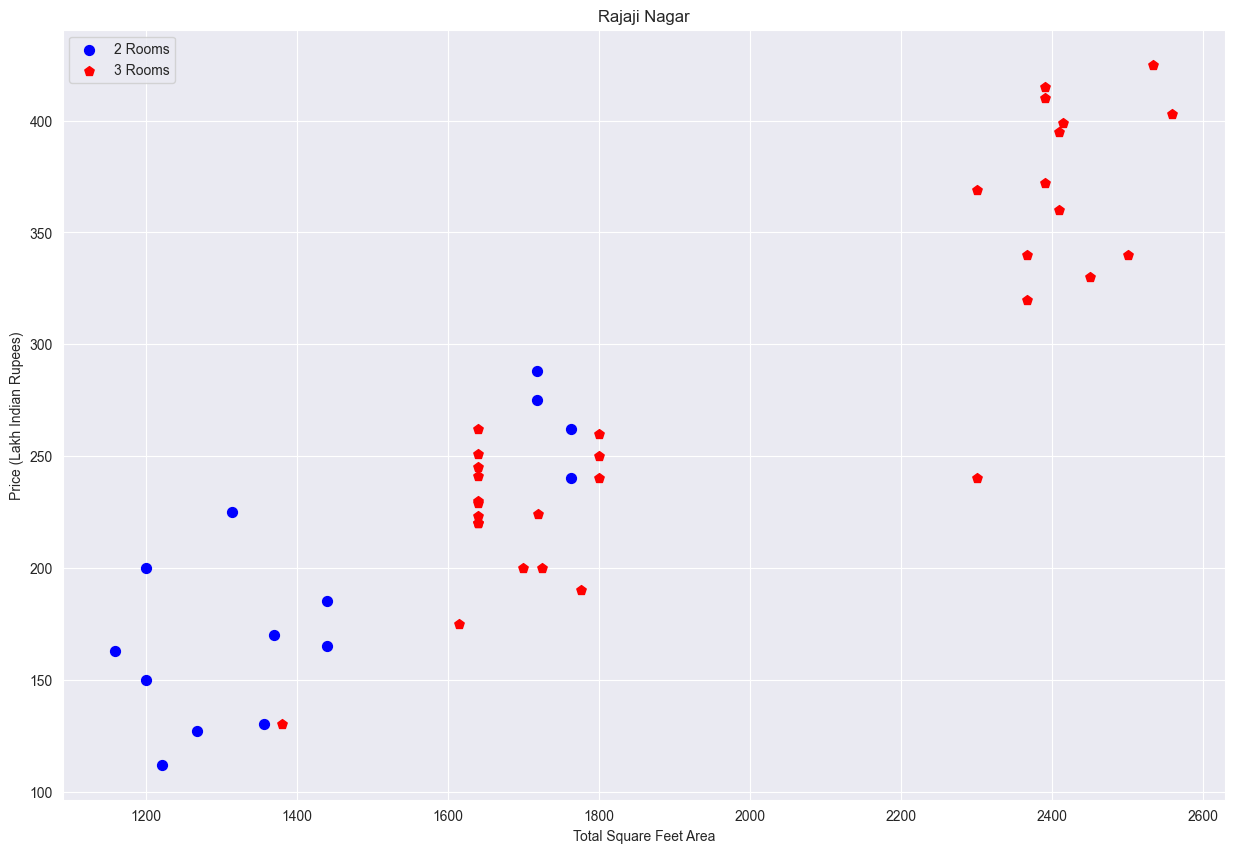

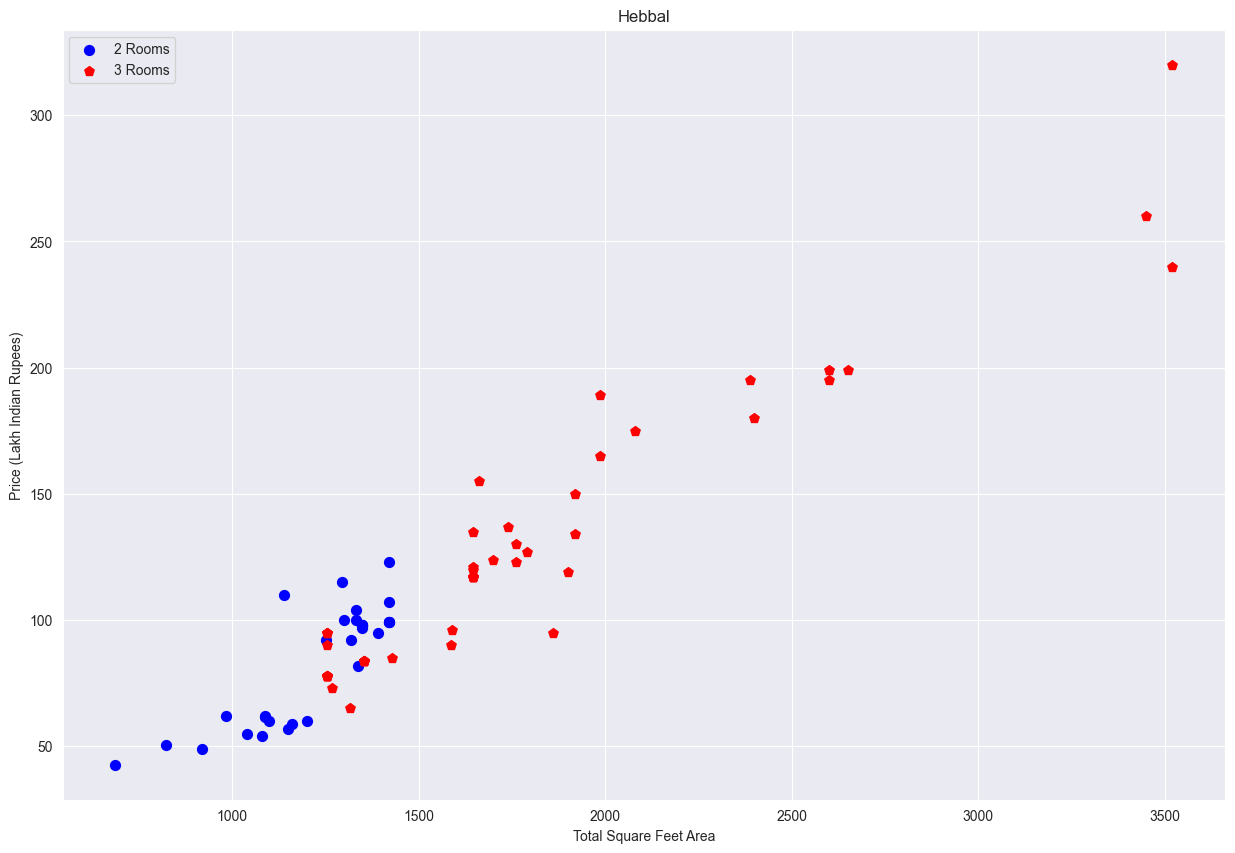

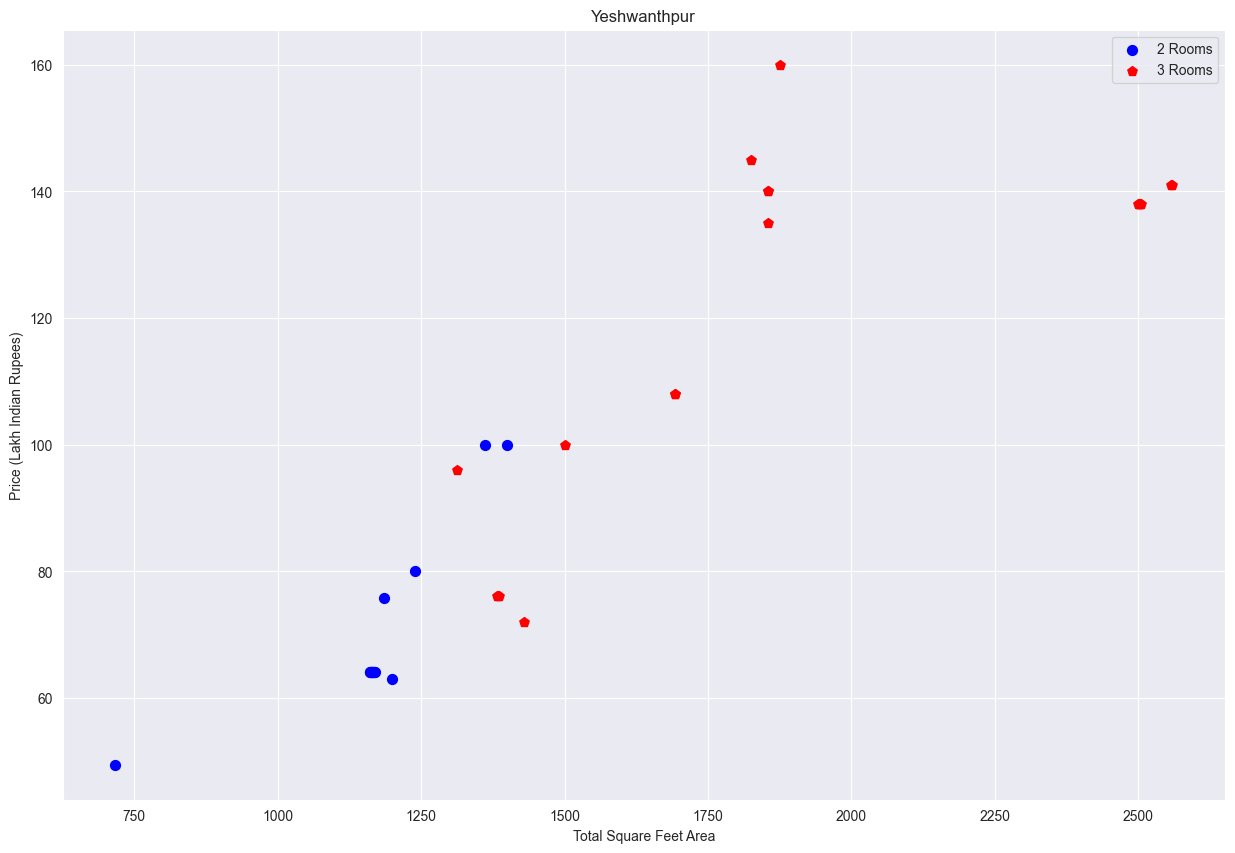

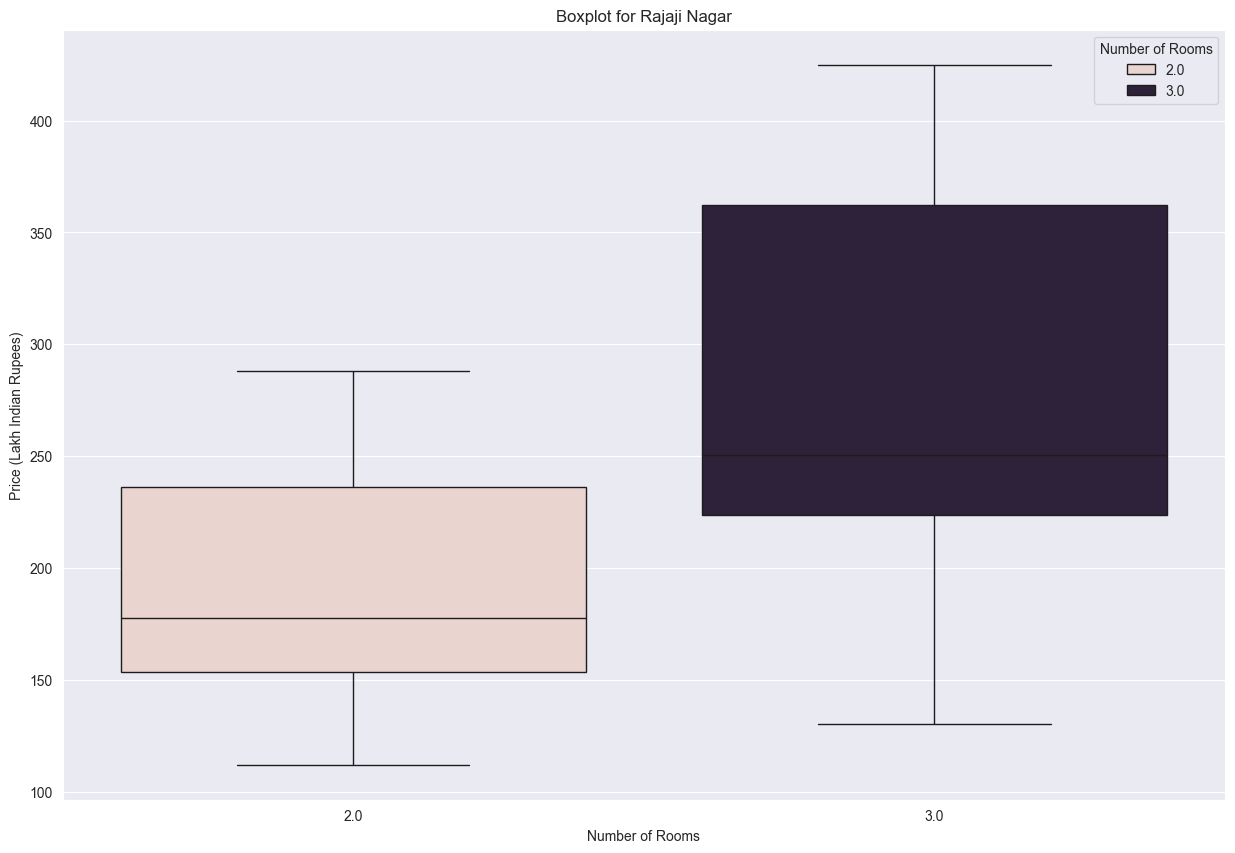

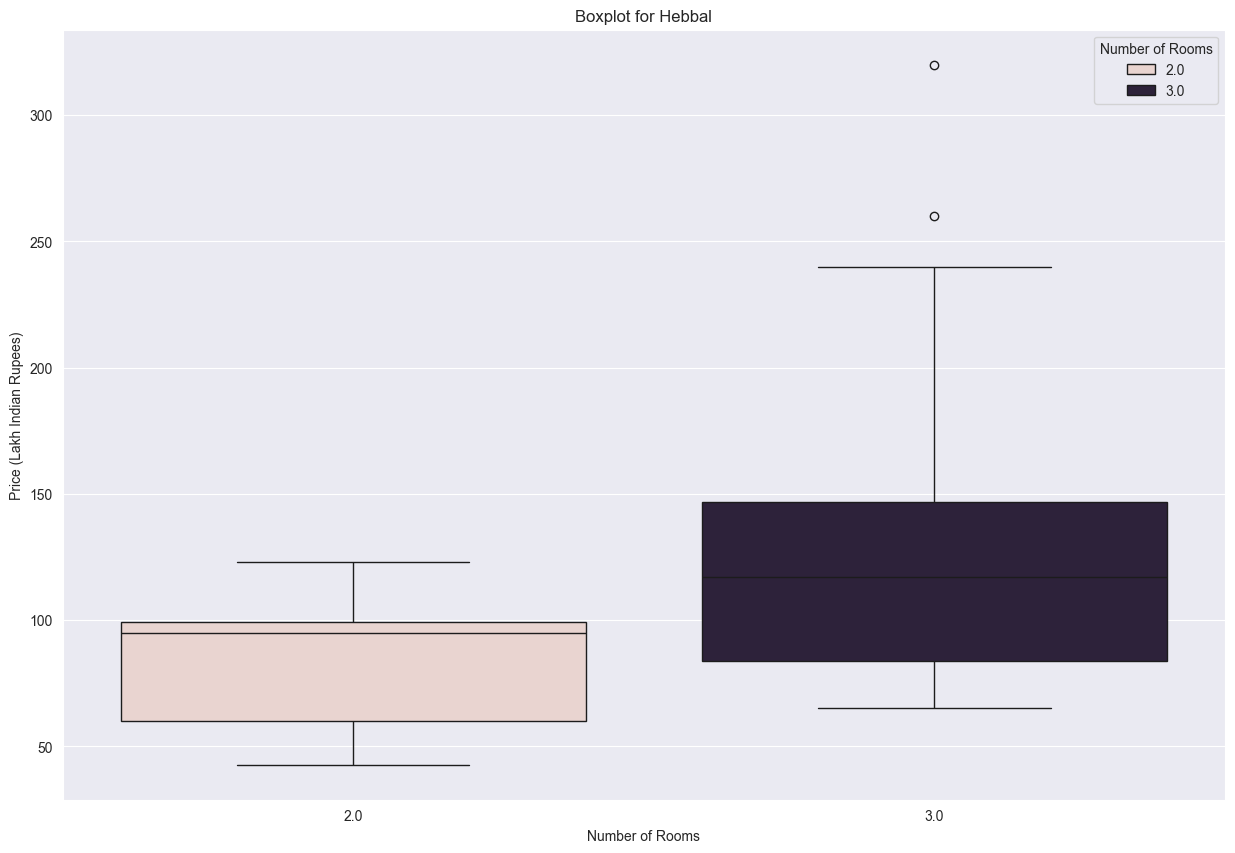

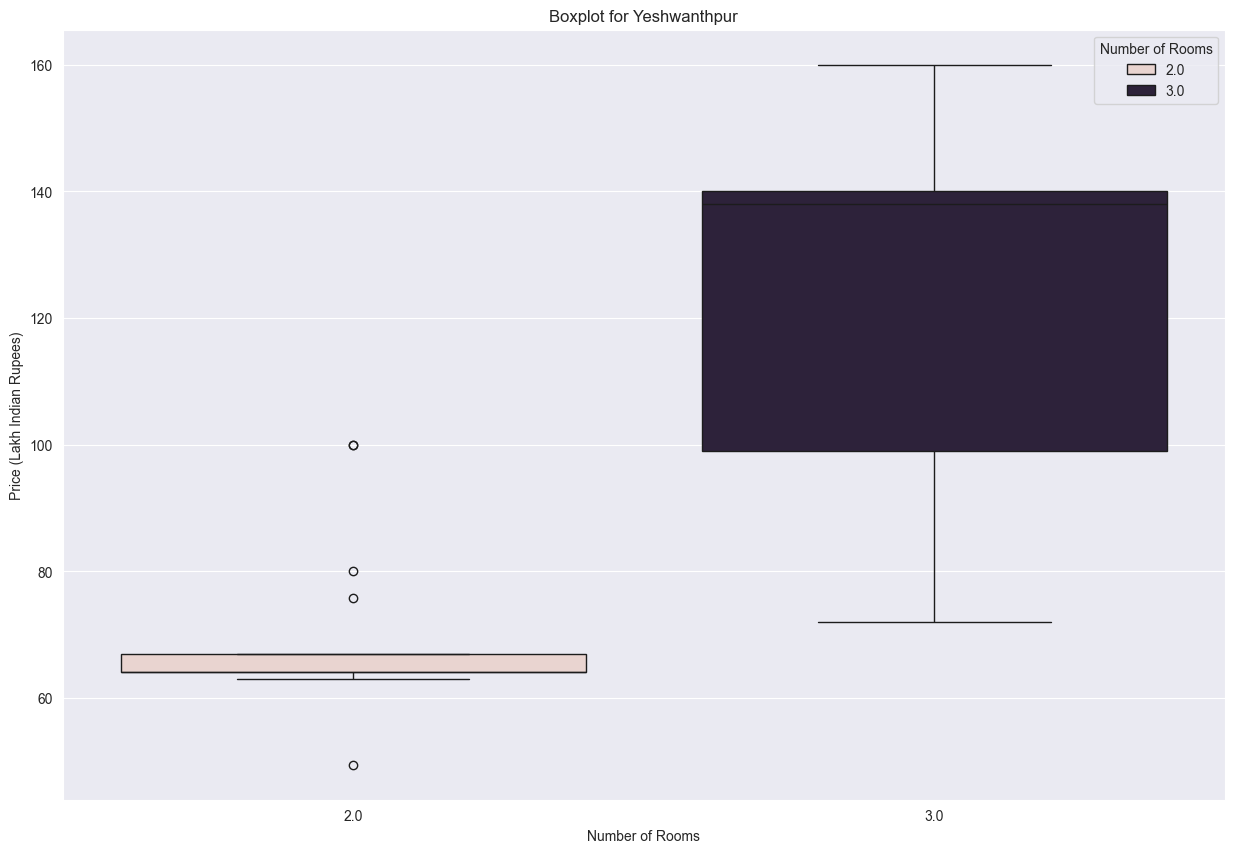

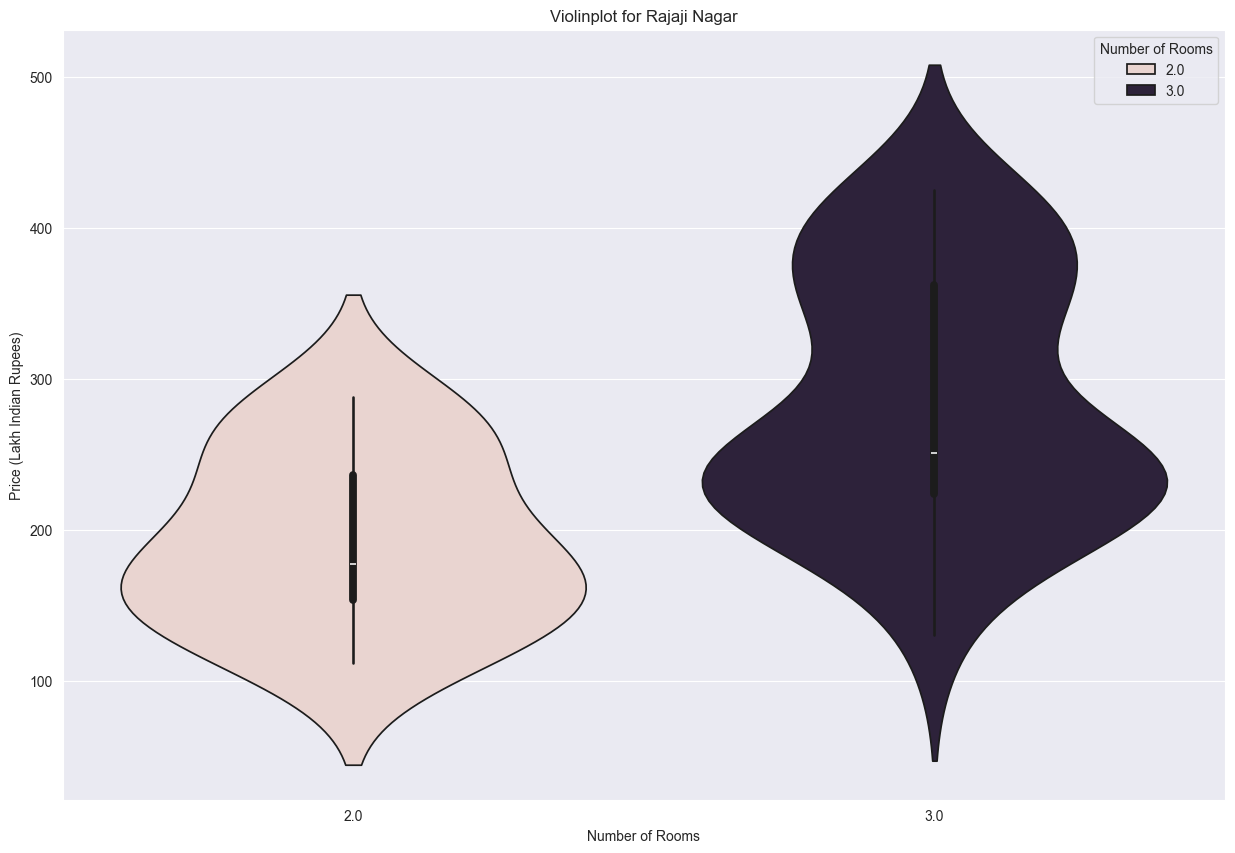

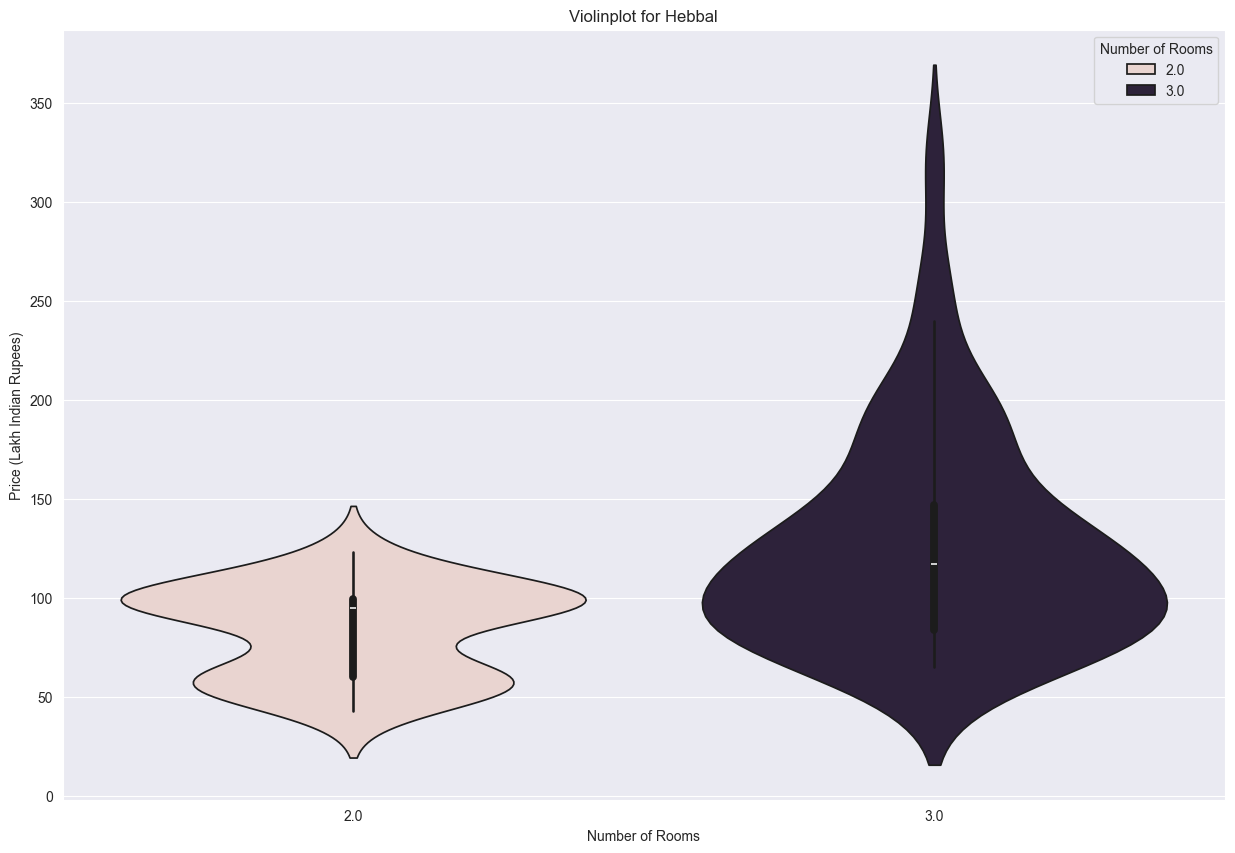

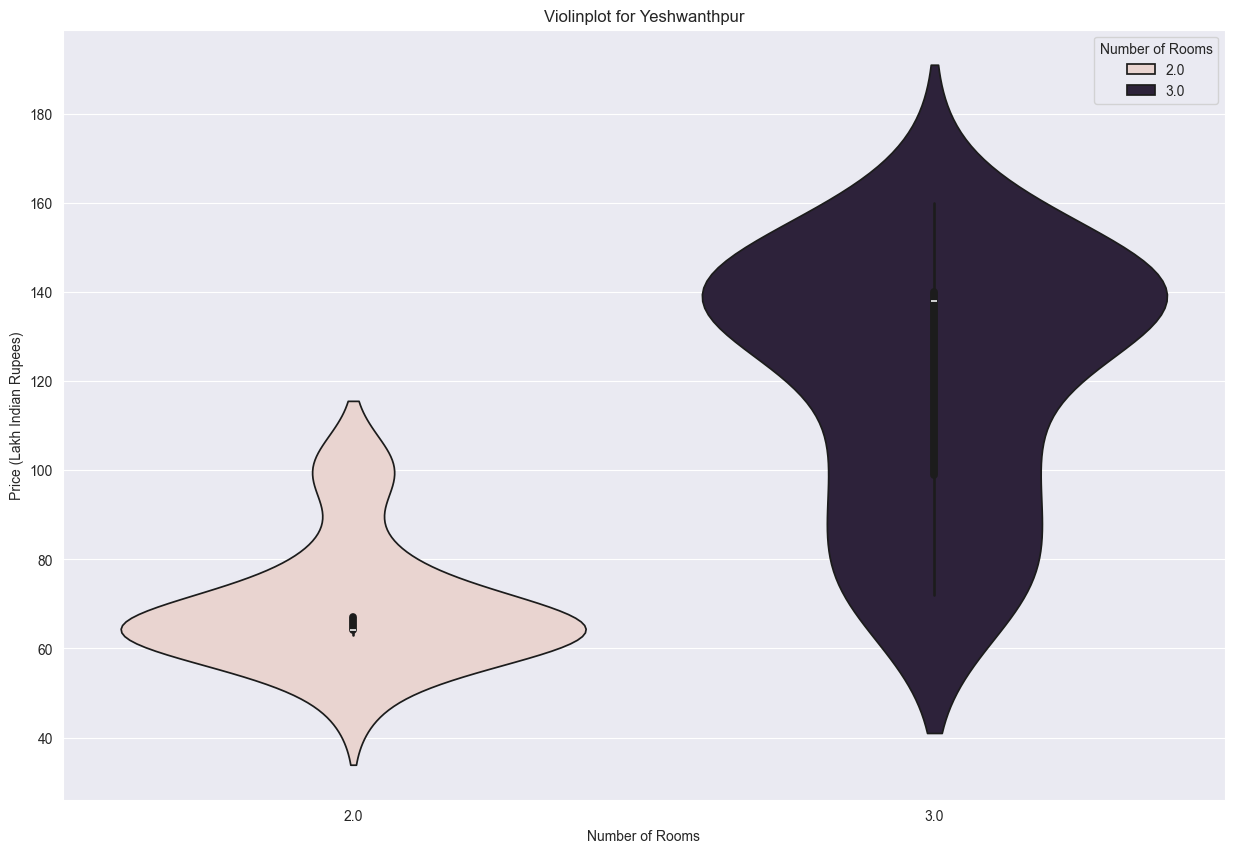

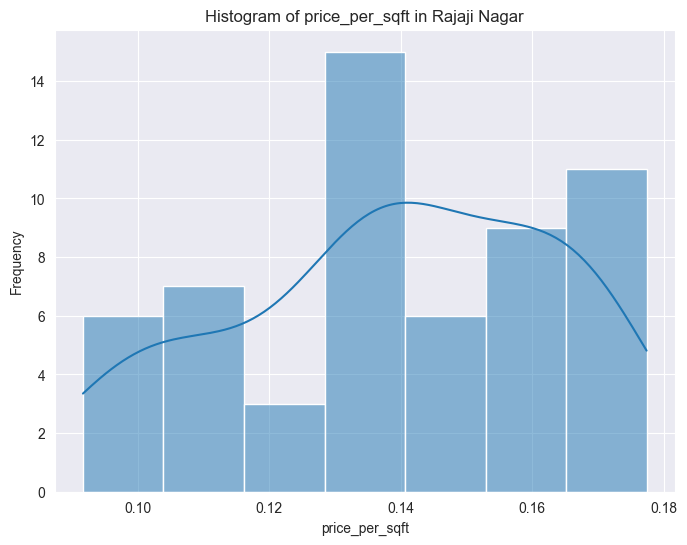

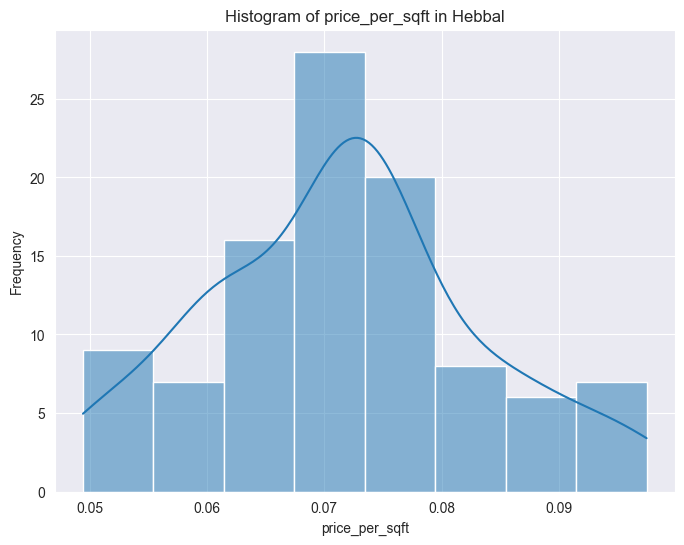

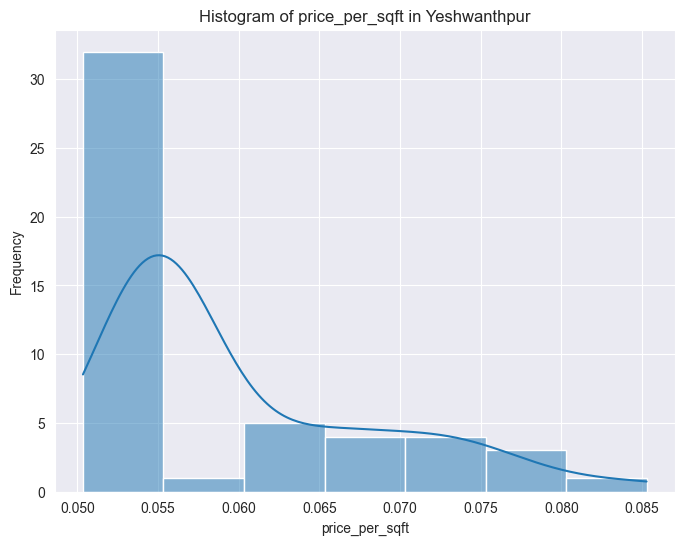

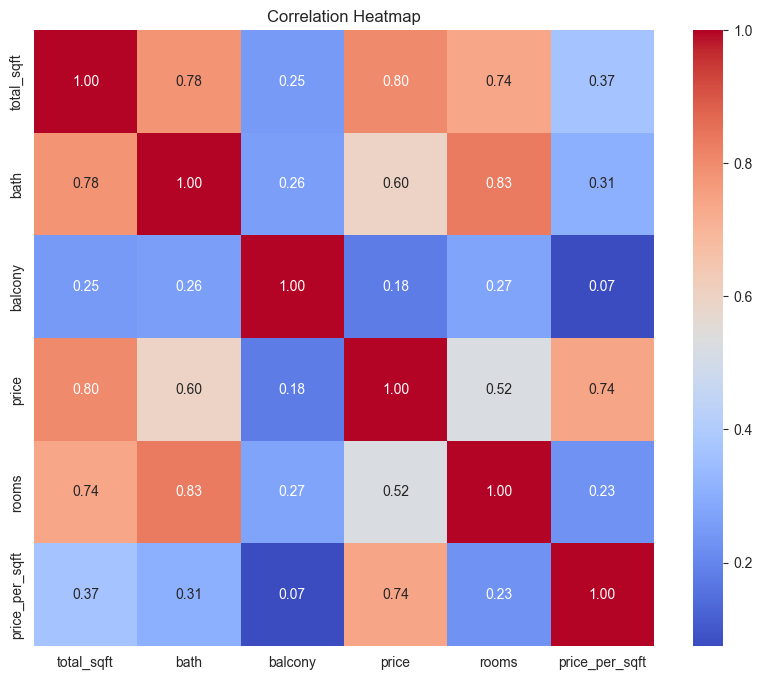

In [17]:
# See the scatter plots before the second removal
vd.plot_scatter_chart(removePriceLocation.data_train, "Rajaji Nagar")
vd.plot_scatter_chart(removePriceLocation.data_train, "Hebbal")
vd.plot_scatter_chart(removePriceLocation.data_train, "Yeshwanthpur")

# Show data before the second removal in box plots
vd.plot_boxplot(removePriceLocation.data_train, "Rajaji Nagar")
vd.plot_boxplot(removePriceLocation.data_train, "Hebbal")
vd.plot_boxplot(removePriceLocation.data_train, "Yeshwanthpur")

# Show data before the second removals in violins plot
vd.plot_violinplot(removePriceLocation.data_train, "Rajaji Nagar")
vd.plot_violinplot(removePriceLocation.data_train, "Hebbal")
vd.plot_violinplot(removePriceLocation.data_train, "Yeshwanthpur")

# Show data before the second removal in histograms
vd.plot_histogram(removePriceLocation.data_train, "price_per_sqft", "Rajaji Nagar")
vd.plot_histogram(removePriceLocation.data_train, "price_per_sqft", "Hebbal")
vd.plot_histogram(removePriceLocation.data_train, "price_per_sqft", "Yeshwanthpur")

# Show heatmap with correlations
vd.plot_heatmap(removePriceLocation.data_train)

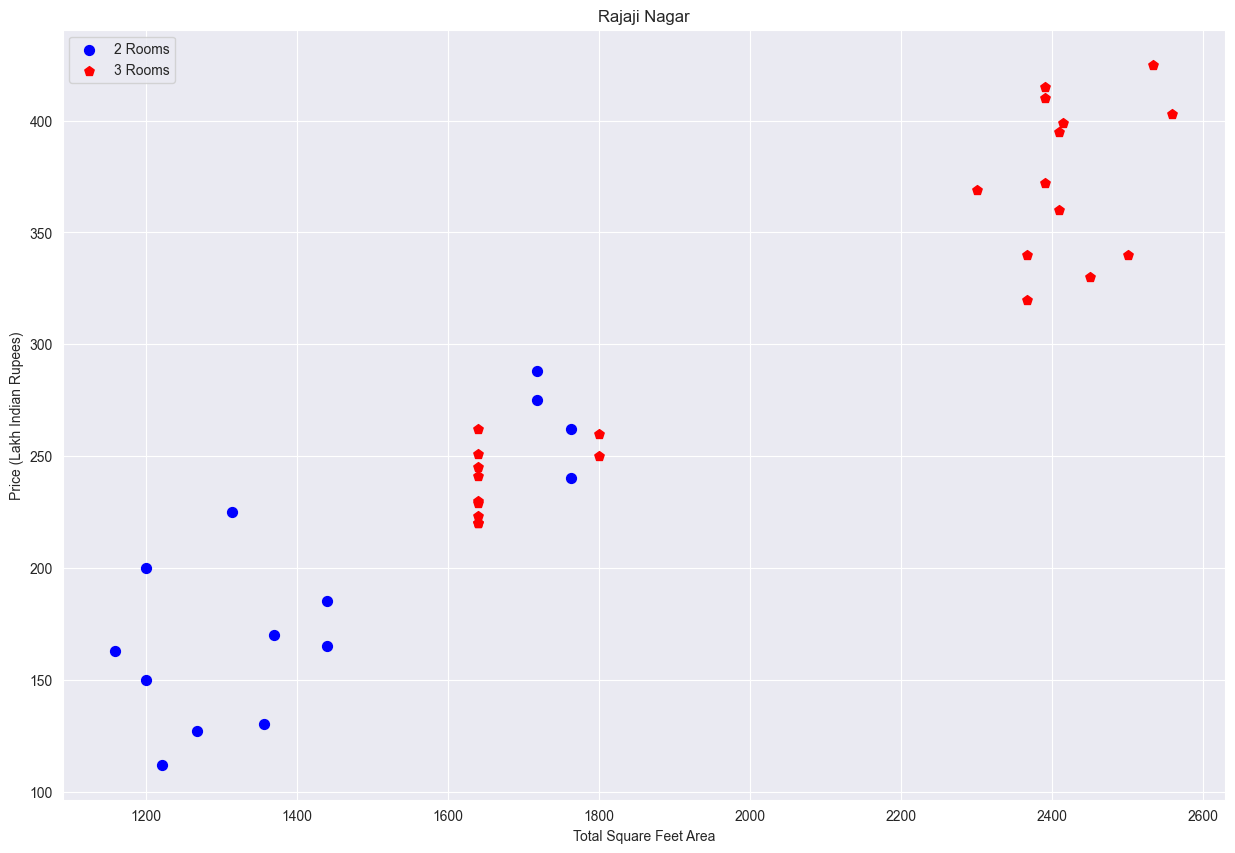

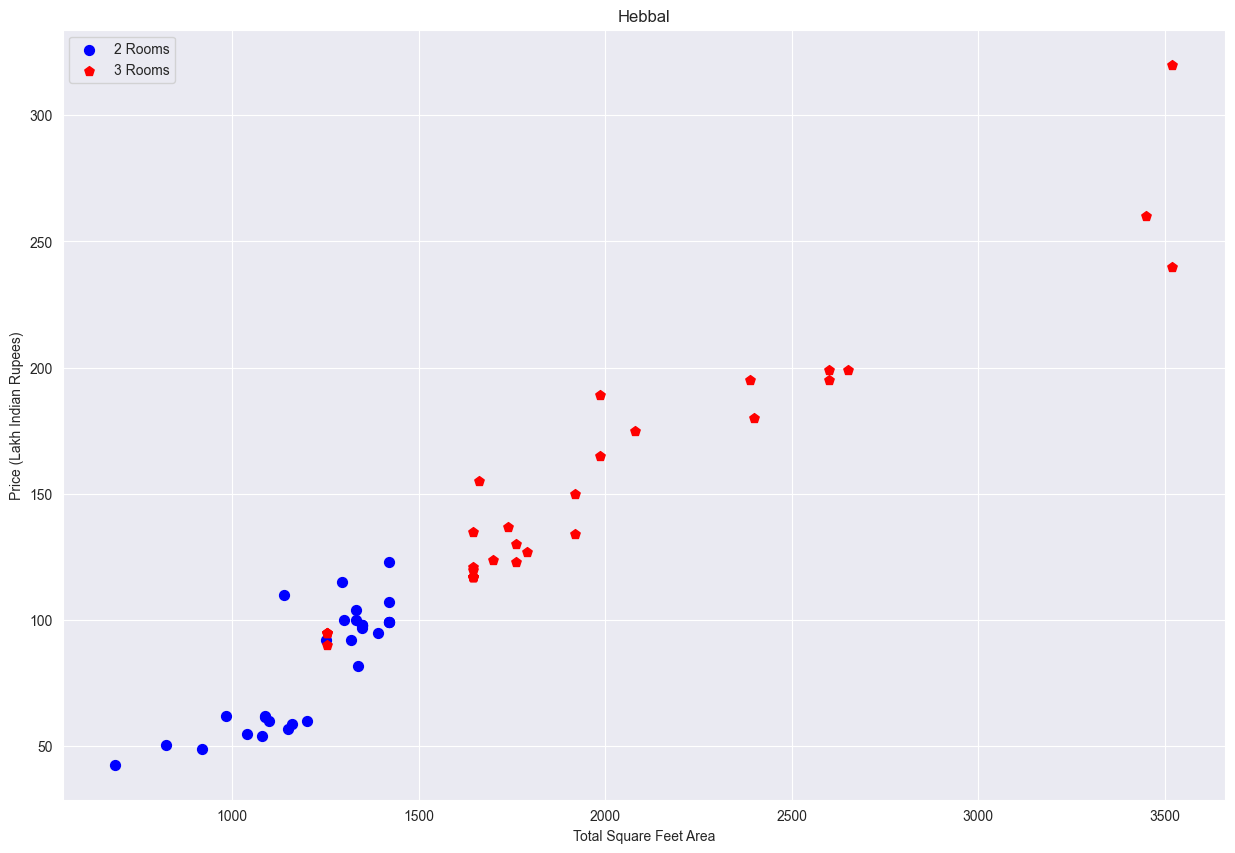

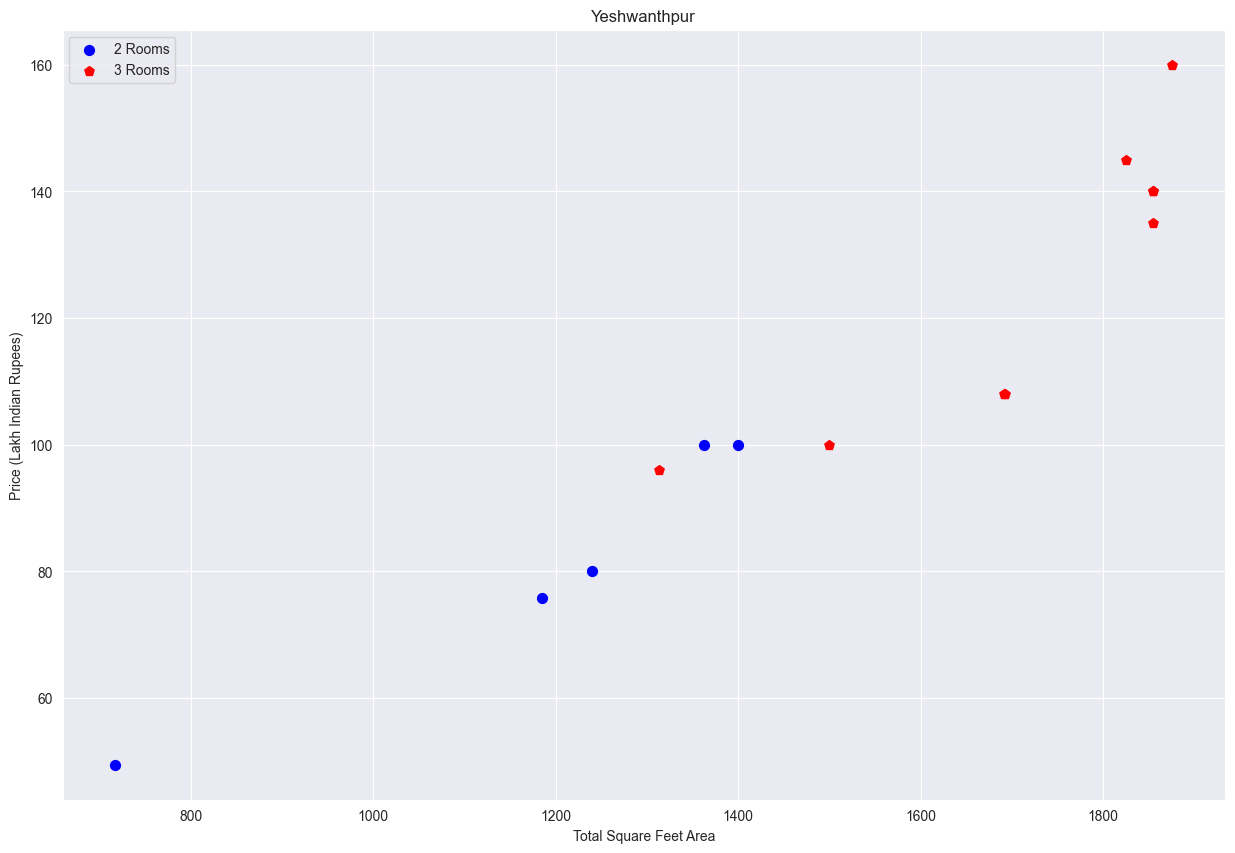

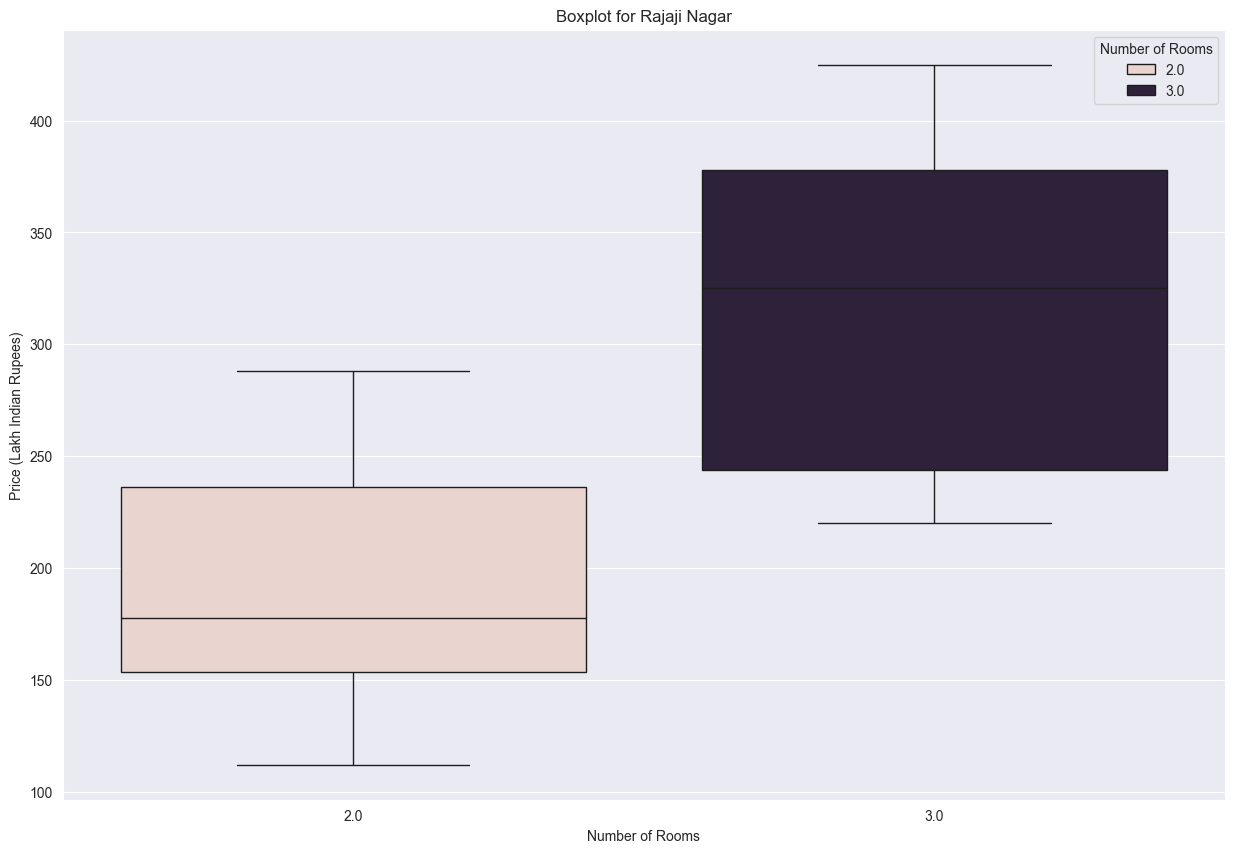

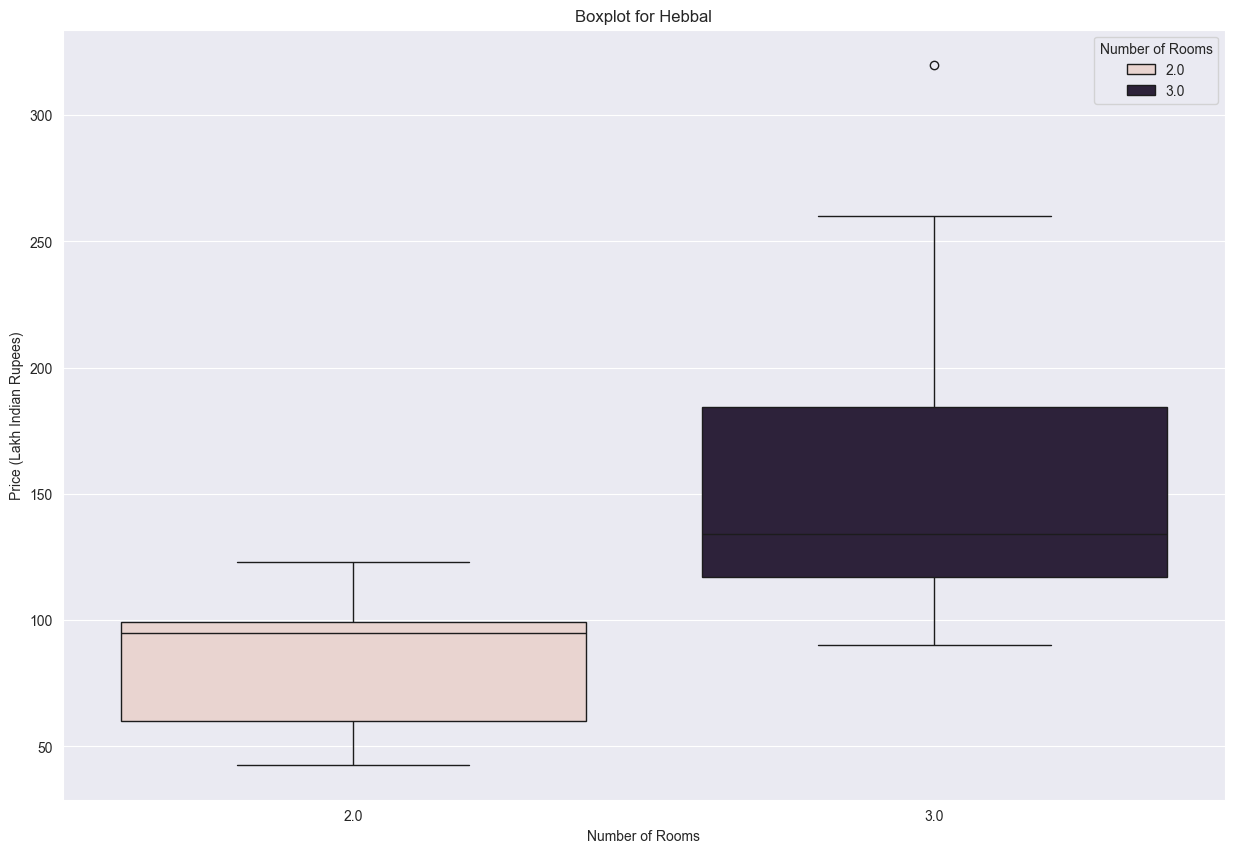

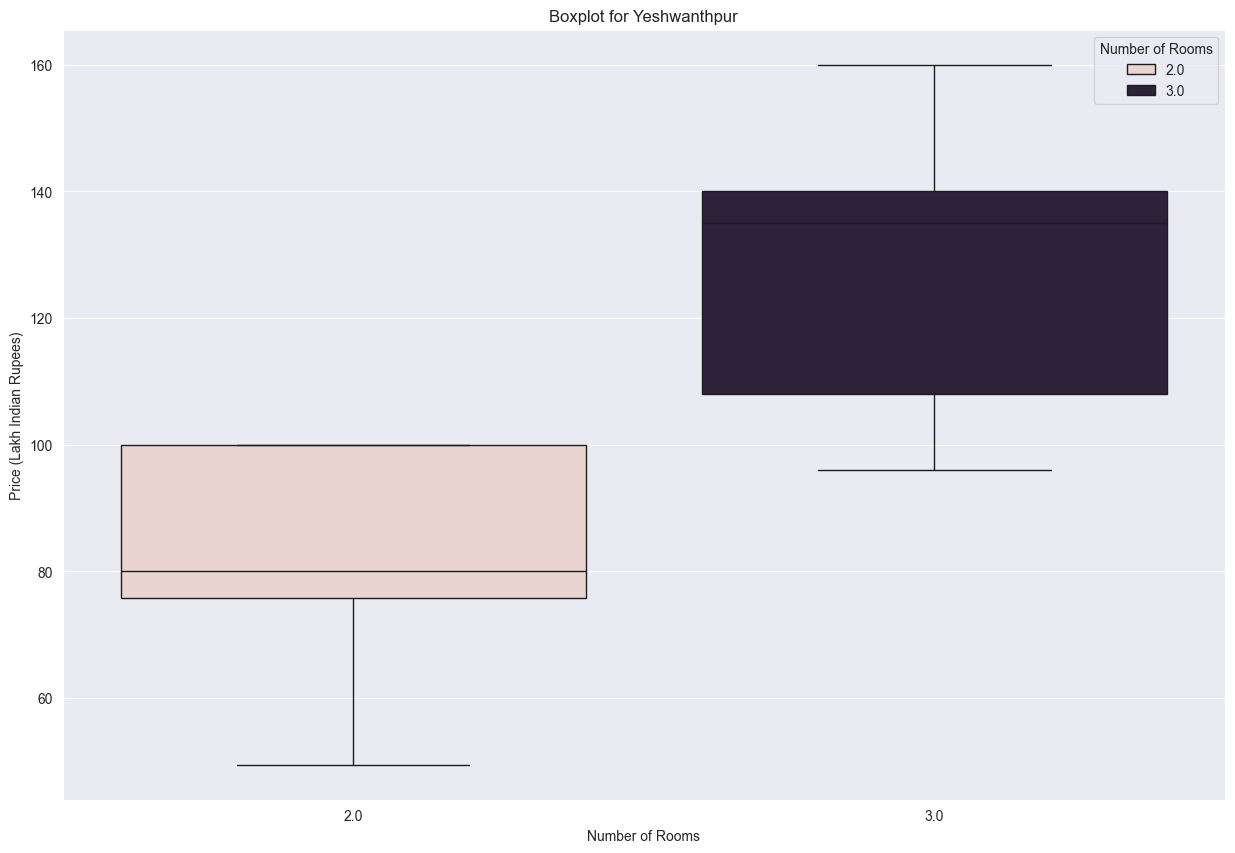

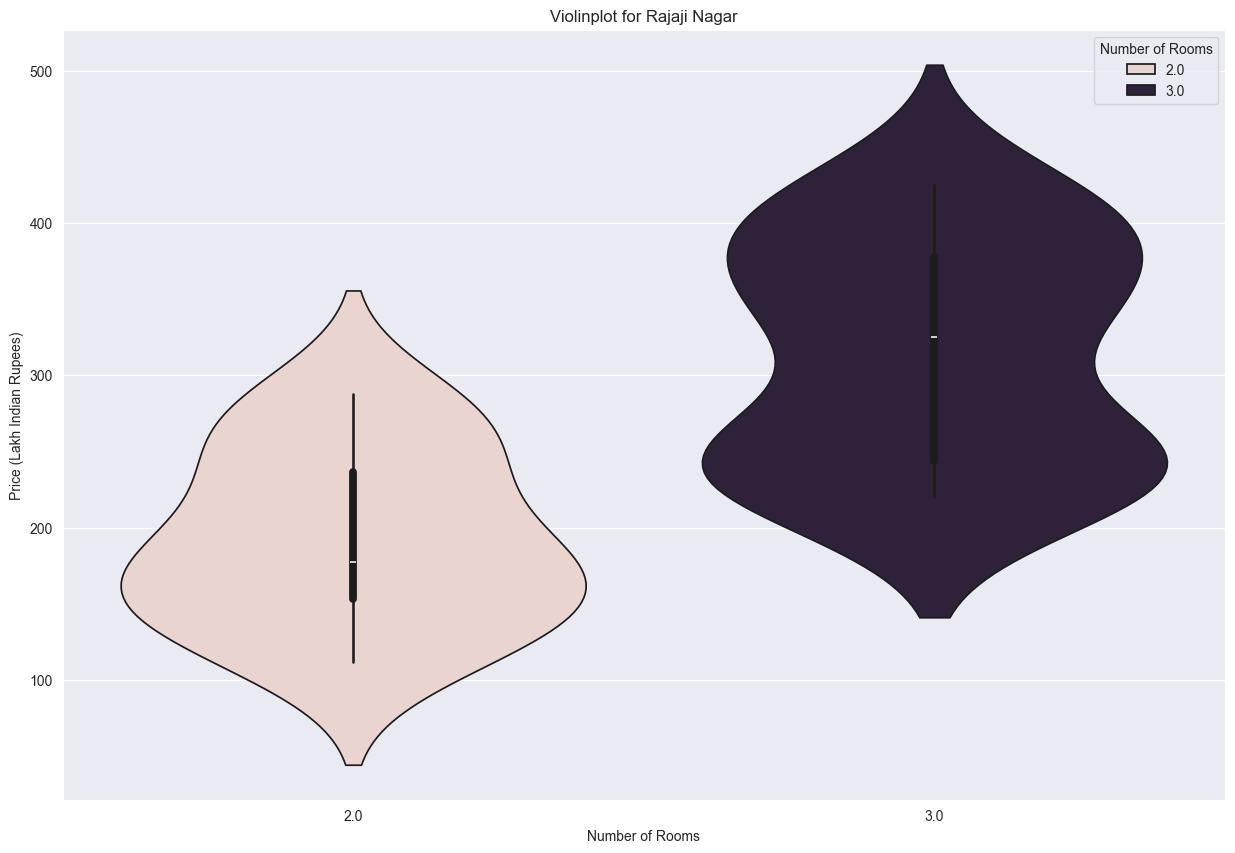

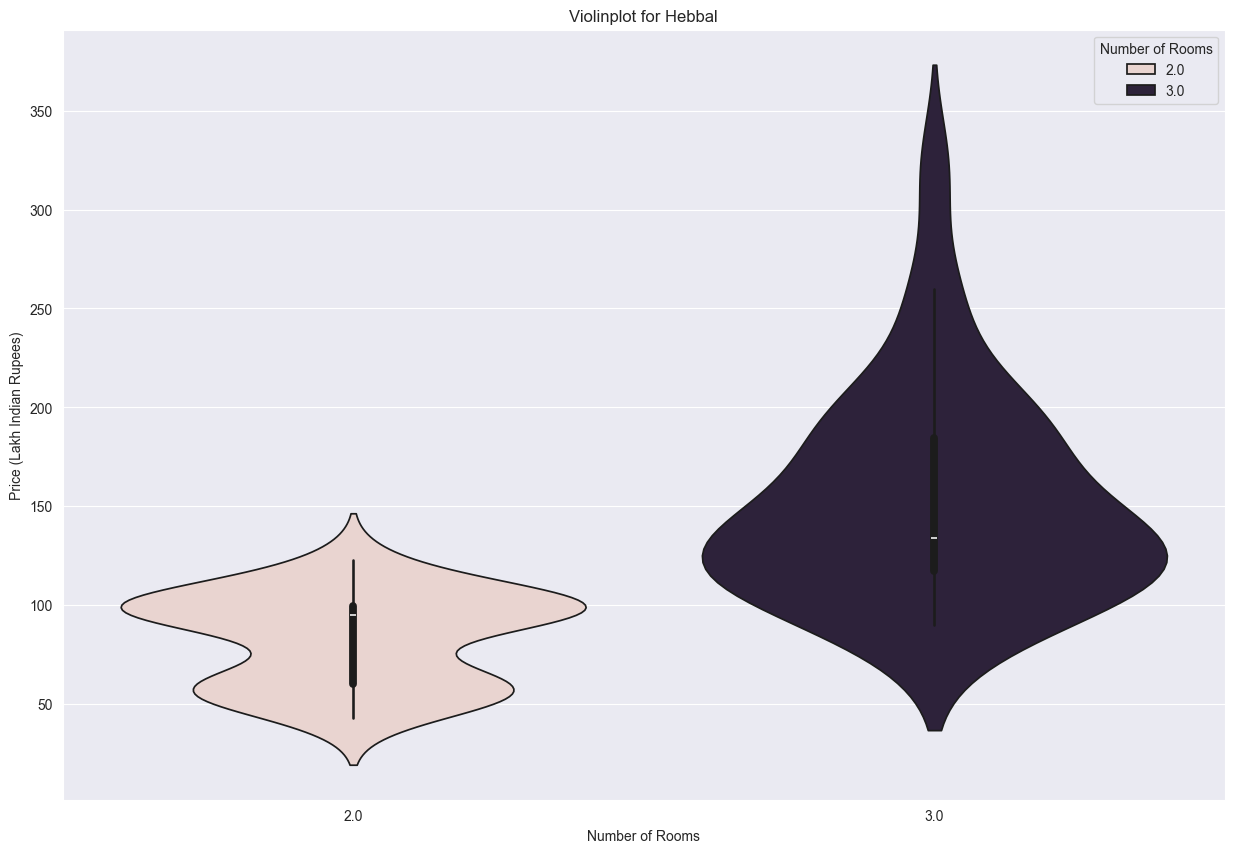

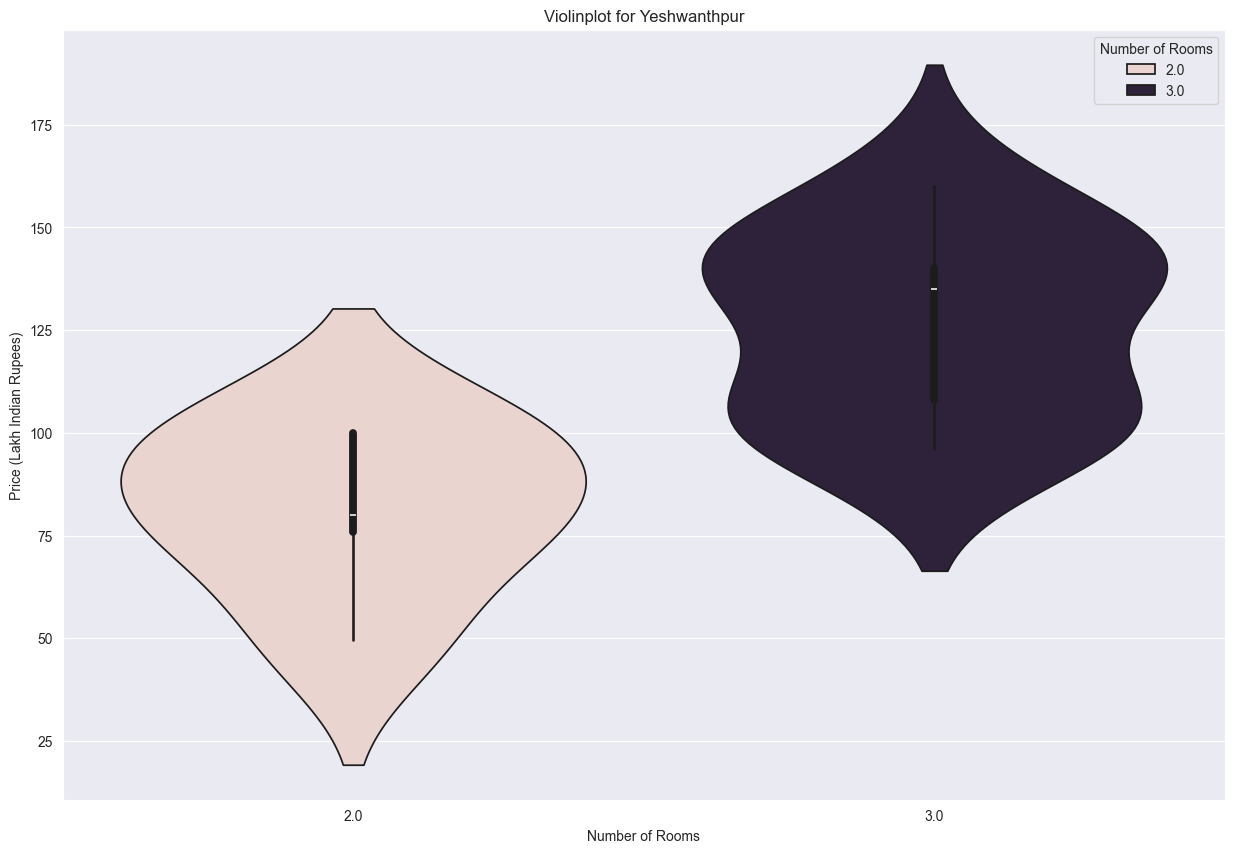

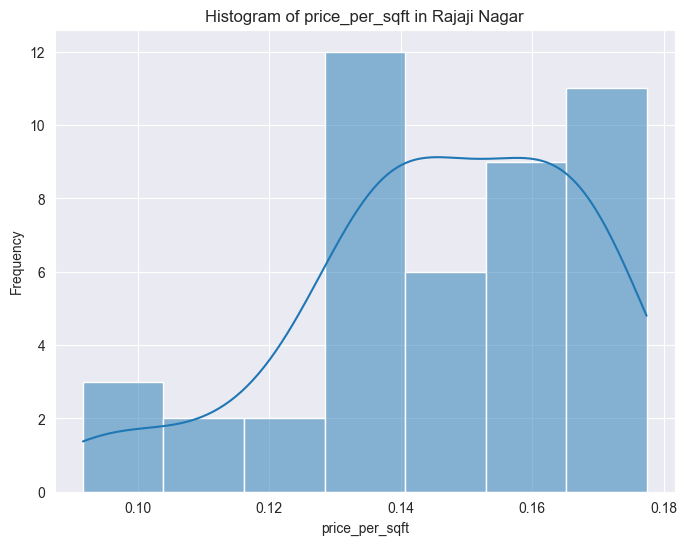

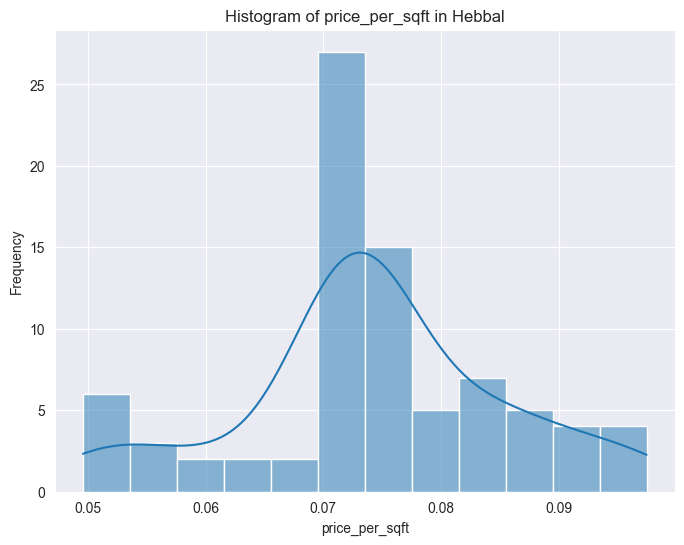

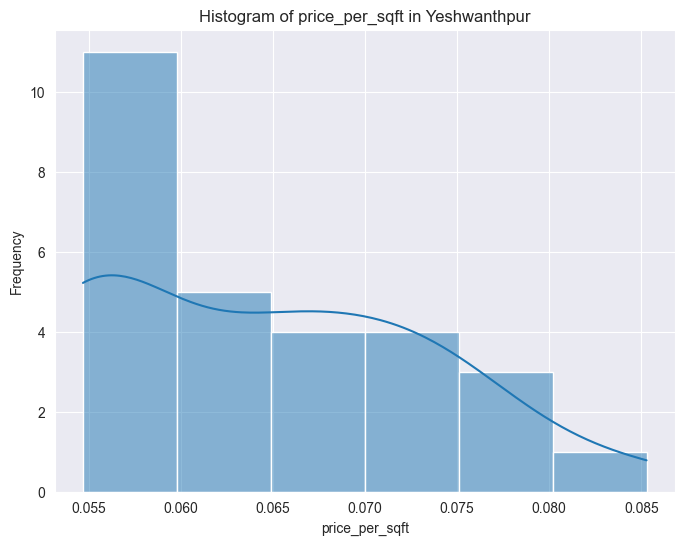

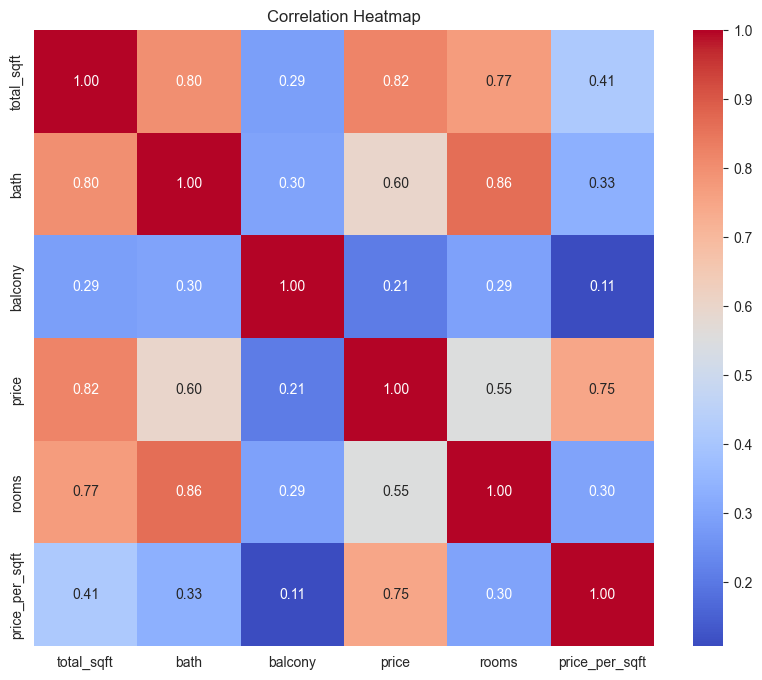

In [18]:
# See the scatter plots after the second removal
vd.plot_scatter_chart(removeBedroom.data_train, "Rajaji Nagar")
vd.plot_scatter_chart(removeBedroom.data_train, "Hebbal")
vd.plot_scatter_chart(removeBedroom.data_train, "Yeshwanthpur")

# Show data after the second removal in box plots
vd.plot_boxplot(removeBedroom.data_train, "Rajaji Nagar")
vd.plot_boxplot(removeBedroom.data_train, "Hebbal")
vd.plot_boxplot(removeBedroom.data_train, "Yeshwanthpur")

# Show data after the second removal in violins plot
vd.plot_violinplot(removeBedroom.data_train, "Rajaji Nagar")
vd.plot_violinplot(removeBedroom.data_train, "Hebbal")
vd.plot_violinplot(removeBedroom.data_train, "Yeshwanthpur")

# Show data after the second removal in histograms
vd.plot_histogram(removeBedroom.data_train, "price_per_sqft", "Rajaji Nagar")
vd.plot_histogram(removeBedroom.data_train, "price_per_sqft", "Hebbal")
vd.plot_histogram(removeBedroom.data_train, "price_per_sqft", "Yeshwanthpur")

# Show heatmap with correlations
vd.plot_heatmap(removeBedroom.data_train)

### Class to do PCA and UMAP

In [19]:
class DimensionalityReduction:
    def __init__(self, data, targets):
        """
        Initialize the DimensionalityReduction object with the dataset.

        Parameters:
        - data: The dataset to perform dimensionality reduction on.
        - targets: The targets of the samples.
        """
        self.data = StandardScaler().fit_transform(data)
        self.targets = targets

    def compute_pca(self, n_components=3):
        """
        Compute Principal Component Analysis (PCA) on the dataset.

        Parameters:
        - n_components: The number of components to keep.

        Returns:
        - pca_projection: The projected data using PCA.
        """
        return PCA(n_components=n_components).fit_transform(self.data)

    def compute_umap(self, n_components=2, n_neighbors=8, min_dist=0.5, metric='euclidean'):
        """
        Compute Uniform Manifold Approximation and Projection (UMAP) on the dataset.

        Parameters:
        - n_components: The number of components to embed the data into.
        - n_neighbors: The number of neighbors to consider for each point.
        - min_dist: The minimum distance between embedded points.
        - metric: The distance metric to use.

        Returns:
        - umap_projection: The projected data using UMAP.
        """
        return umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist,
                         metric=metric).fit_transform(self.data)

    def plot_projection(self, projection, title):
        """
        Plot the 2D projection of the dataset.

        Parameters:
        - projection: The projected data.
        - title: The title of the plot.
        """
        plt.figure(figsize=(8, 6))
        plt.scatter(projection[:, 0], projection[:, 1], c=self.targets, alpha=0.5)
        plt.title(title)
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.grid(True)
        plt.show()

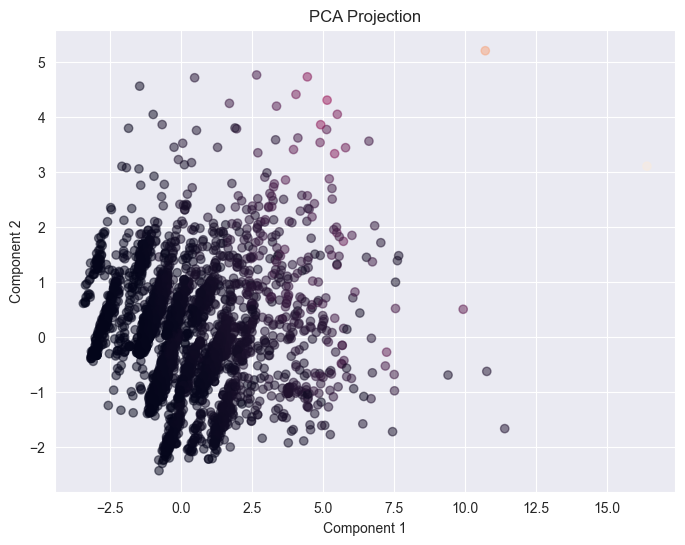

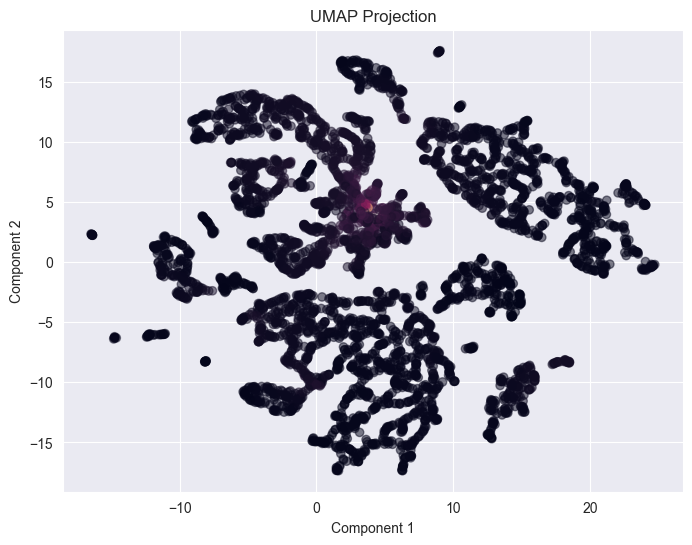

In [20]:
# Our data
data = removeBedroom.data_train[['total_sqft', 'bath', 'balcony', 'rooms', 'price_per_sqft']]

# Our target
targets = removeBedroom.labels_train

# Initialize DimensionalityReduction object
dr = DimensionalityReduction(data, targets)

# Show PCA Projection
dr.plot_projection(dr.compute_pca(), 'PCA Projection')

# Show UMAP Projection
dr.plot_projection(dr.compute_umap(), 'UMAP Projection')

### Class to do Hypothesis Test

In [21]:
class HypothesisTester:
    """
    The t-test assumes that the data is normally distributed and that the variances are equal between groups (for
    unpaired t-test) or within groups (for paired t-test).
    The ANOVA test assumes that the data is normally distributed and that the variances are equal between groups.
    """
    def unpaired_t_test(self, group1, group2):
        """
        Perform unpaired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_ind(group1, group2)
        return t_statistic, p_value

    def unpaired_anova(self, *groups):
        """
        Perform unpaired ANOVA for more than two groups.

        Parameters:
        - *groups: Variable length argument containing data for each group. Each argument should be a list or array-like
        object.

        Returns:
        - f_statistic: The calculated F-statistic.
        - p_value: The p-value associated with the F-statistic.
        """
        f_statistic, p_value = f_oneway(*groups)
        return f_statistic, p_value

    def paired_t_test(self, group1, group2):
        """
        Perform paired t-test for two groups.

        Parameters:
        - group1: List or array-like object containing data for group 1.
        - group2: List or array-like object containing data for group 2.
                  Should have the same length as group1.

        Returns:
        - t_statistic: The calculated t-statistic.
        - p_value: The p-value associated with the t-statistic.
        """
        t_statistic, p_value = ttest_rel(group1, group2)
        return t_statistic, p_value

In [22]:
# Prices per SQq. feet for three locations
data = removeBedroom.data_train

price_sqft_Rajaji_Nagar = data[data['location'] == 'Rajaji Nagar']['price_per_sqft']
price_sqft_Hebbal = data[data['location'] == 'Hebbal']['price_per_sqft']
price_sqft_Yeshwanthpur = data[data['location'] == 'Yeshwanthpur']['price_per_sqft']

# Prices for Rajaji Nagar location
price_Rajaji_Nagar = data[data['location'] == 'Rajaji Nagar']['price']

# Total Sq. Feet for Rajaji Nagar location
total_sqft_Rajaji_Nagar = data[data['location'] == 'Rajaji Nagar']['total_sqft']

In [23]:
# Initialize the HypothesisTester class with the data
tester = HypothesisTester()

In [24]:
# Perform unpaired t-test between Hebbal and Rajaji Nagar locations
t_stat, p_val = tester.unpaired_t_test(price_sqft_Hebbal, price_sqft_Rajaji_Nagar)

print("\nUnpaired t-test between Hebbal and Rajaji Nagar locations:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Unpaired t-test between Hebbal and Rajaji Nagar locations:
t-statistic: -25.096796946463733
p-value: 1.2074383373605297e-50


**Unpaired t-test between Hebbal and Rajaji Nagar locations:**
- t-statistic: The calculated t-statistic is approximately -23.39 (indicates that, on average, the price per Sq. Feet of Hebbal locations are lower than those of the Rajaji Nagar locations). This value represents the difference in means between the price per Sq. Feet of Hebbal and Rajaji Nagar locations.
* p-value: The p-value associated with the t-statistic is approximately 1.13e-47. This p-value is very small, indicating strong evidence against the null hypothesis.
+ In this case, it suggests that the difference in price per Sq. Feet between Hebbal and Rajaji Nagar locations is statistically significant.

In [25]:
# Perform unpaired ANOVA among the three locations
f_stat, p_val_anova = tester.unpaired_anova(price_sqft_Rajaji_Nagar, price_sqft_Hebbal, price_sqft_Yeshwanthpur)

print("\nUnpaired ANOVA among three locations:")
print("F-statistic:", f_stat)
print("p-value:", p_val_anova)


Unpaired ANOVA among three locations:
F-statistic: 424.58339596389806
p-value: 6.048163951604919e-63


**Unpaired ANOVA among all three locations:**
- F-statistic: The calculated F-statistic is approximately 354.19 This value represents the ratio of variability between groups to variability within groups in price per Sq. Feet among three locations.
* p-value: The p-value associated with the F-statistic is approximately 4.12e-59. The t-test, this p-value is extremely small, indicating strong evidence against the null hypothesis.
+ It suggests that there is a statistically significant difference in price per Sq. Feet among at least one pair of locations.

In [26]:
# Perform paired t-test for total_sqft and price within Rajaji Nagar location
t_stat, p_val = tester.paired_t_test(total_sqft_Rajaji_Nagar, price_Rajaji_Nagar)

print("\nPaired t-test for total_sqft and price within Rajaji Nagar location:")
print("t-statistic:", t_stat)
print("p-value:", p_val)


Paired t-test for total_sqft and price within Rajaji Nagar location:
t-statistic: 20.461746128922645
p-value: 4.151245437733103e-24


**Paired t-test for total_sqft and price within Rajaji Nabar location:**
- t-statistic: The calculated t-statistic is approximately 18.56. This value represents the difference in means between total_sqft and price within the Rajaji Nagar location relative to the variability in the data.
* p-value: The p-value associated with the t-statistic is approximately 2.93e-21. This p-value is extremely small, indicating strong evidence against the null hypothesis.
+ It suggests that the difference between total_sqft and price within the Rajaji Nagar location is statistically significant.

### New Features

In [27]:
class FeatureEngineering:
    """
    A class for feature engineering on the dataset
    """
    def __init__(self, data_loader):
        """
        Initializes the FeatureEngineering object

        :param data_loader: The input dataset
        """
        self.data_loader = data_loader
        self.data_train = None
        self.labels_train = None
        self.data_test = None
        self.labels_test = None
        
    def create_features(self):
        """
        Creates new features based on the existing data
        """
        self.data_train = self.data_loader.data_train
        self.labels_train = self.data_loader.labels_train
        self.data_test = self.data_loader.data_test
        self.labels_test = self.data_loader.labels_test
        
        # Price distribution per bedroom.
        self.data_train['price_per_bedroom'] = self.data_train['price'] / self.data_train['rooms']
        self.data_test['price_per_bedroom'] = self.data_test['price'] / self.data_test['rooms']
        
        # Bathroom to bedroom ratio.
        self.data_train['bath_per_bedroom'] = self.data_train['bath'] / self.data_train['rooms']
        self.data_test['bath_per_bedroom'] = self.data_test['bath'] / self.data_test['rooms']
        
        # Space distribution per bedroom.
        self.data_train['total_sqft_per_room'] = self.data_train['total_sqft'] / self.data_train['rooms']
        self.data_test['total_sqft_per_room'] = self.data_test['total_sqft'] / self.data_test['rooms']
        
        # Balcony to bedroom ratio
        self.data_train['balcony_per_room'] = self.data_train['balcony'] / self.data_train['rooms']
        self.data_test['balcony_per_room'] = self.data_test['balcony'] / self.data_test['rooms']
        
        # Price distribution per bathroom
        self.data_train['price_per_bath'] = self.data_train['price'] / self.data_train['bath']
        self.data_test['price_per_bath'] = self.data_test['price'] / self.data_test['bath']
        
        # Space distribution per bathroom
        self.data_train['total_sqft_per_bath'] = self.data_train['total_sqft'] / self.data_train['bath']
        self.data_test['total_sqft_per_bath'] = self.data_test['total_sqft'] / self.data_test['bath']
        
        # Balcony to bathroom ratio
        self.data_train['balcony_per_bath'] = self.data_train['balcony'] / self.data_train['bath']
        self.data_test['balcony_per_bath'] = self.data_test['balcony'] / self.data_test['bath']
        
        # Price distribution per balcony
        self.data_train['price_per_balcony'] = self.data_train['price'] / self.data_train['balcony']
        self.data_test['price_per_balcony'] = self.data_test['price'] / self.data_test['balcony']
        
        # Space distribution per balcony
        self.data_train['total_sqft_per_balcony'] = self.data_train['total_sqft'] / self.data_train['balcony']
        self.data_test['total_sqft_per_balcony'] = self.data_test['total_sqft'] / self.data_test['balcony']
        
        # Bedroom to bathroom ratio
        self.data_train['room_per_bath'] = self.data_train['rooms'] / self.data_train['bath']
        self.data_test['room_per_bath'] = self.data_test['rooms'] / self.data_test['bath']
        
        # Calculate the average price
        average_price_train = self.data_train['price'].mean()
        average_price_test = self.data_test['price'].mean()
        
        # Prices above average
        self.data_train['price_above_average'] = self.data_train['price'] > average_price_train
        self.data_test['price_above_average'] = self.data_test['price'] > average_price_test

In [28]:
new_features = FeatureEngineering(removeBedroom)
new_features.create_features()

# Access the data and labels attributes
print("Training data shape:", new_features.data_train.shape)
print("Training labels shape:", new_features.labels_train.shape)
print("Testing data shape:", new_features.data_test.shape)
print("Testing labels shape:", new_features.labels_test.shape)

Training data shape: (4598, 18)
Training labels shape: (4598,)
Testing data shape: (1239, 17)
Testing labels shape: (1239,)


C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_2008\917924149.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_test['price_per_bedroom'] = self.data_test['price'] / self.data_test['rooms']
C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_2008\917924149.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data_test['bath_per_bedroom'] = self.data_test['bath'] / self.data_test['rooms']
C:\Users\vitor_pl48eof\AppData\Local\Temp\ipykernel_2008\917924149.py:36: SettingWithCopyWarning: 

### Model Selection Class

In [29]:
class ModelSelection:
    """
    A class to perform model selection for regression problems.
    """
    def __init__(self, X, y):
        """
        Initializes the ModelSelection object with the features and target variable.

        :param X: The input features.
        :param y: The target variable.
        """
        self.X = X
        self.y = y

    def select_model(self):
        """
        Performs model selection by training various models and evaluating them using Mean Squared Error.
        The models used are: Linear Regression, Decision Tree Regression, Random Forest Regression,
        Gradient Boosting Regression, and Support Vector Regression.
        """
        # Create a list of models to evaluate
        models = [RandomForestRegressor(), GradientBoostingRegressor(), LinearRegression(), DecisionTreeRegressor(), SVR(), Ridge()]

        for model in models:
            # Perform K-Fold Cross Validation
            scores = cross_val_score(model, self.X, self.y, cv=10, scoring='neg_mean_squared_error')

            # Calculate Mean Squared Error
            mse_scores = -scores

            # Print the model name and its Mean Squared Error
            print(f'Model: {model.__class__.__name__}, Mean Squared Error: {mse_scores.mean()}')

            #X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)

            # Fit the model to the training data
            model.fit(self.X, self.y)

            # Plot the model's predictions
            self.plot_model_predictions(self.X, self.y, model)

    def plot_model_predictions(self, X_test, y_test, model):
        '''
        Plots the model's predictions against the actual values
        :param X_test: Test data
        :param y_test: Actual values
        :param model: Trained model
        '''

        # Use the model to make predictions on the test data
        predictions = model.predict(X_test)

        # Plot the model's predictions against the actual values
        plt.scatter(y_test, predictions)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model.__class__.__name__} Model: Actual vs Predicted Values')

        # Add a line representing perfect prediction
        min_val = min(min(y_test), min(predictions))
        max_vals = max(max(y_test), max(predictions))
        plt.plot([min_val, max_vals], [min_val, max_vals], color='red')

        plt.show()

### Model Selection

Model: RandomForestRegressor, Mean Squared Error: 435.0566305168648


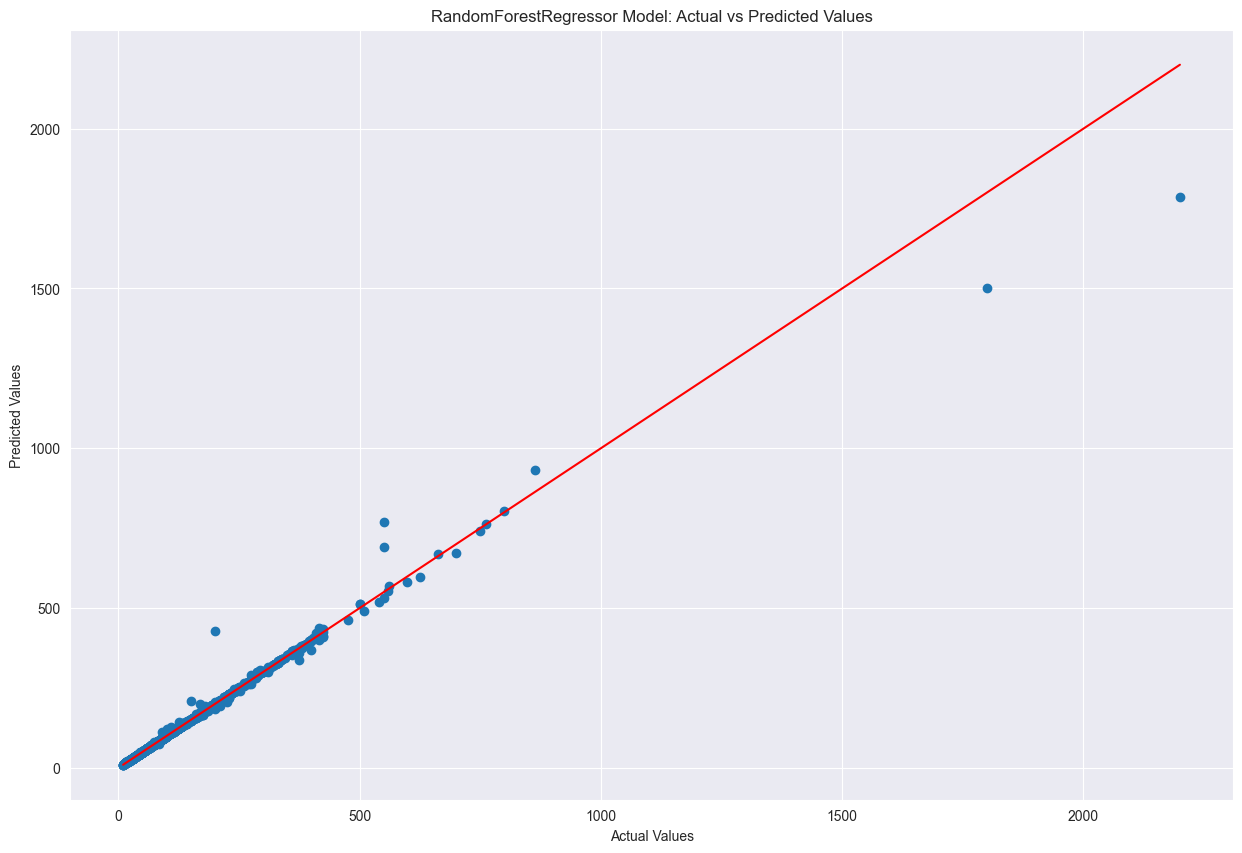

Model: GradientBoostingRegressor, Mean Squared Error: 316.61492783470584


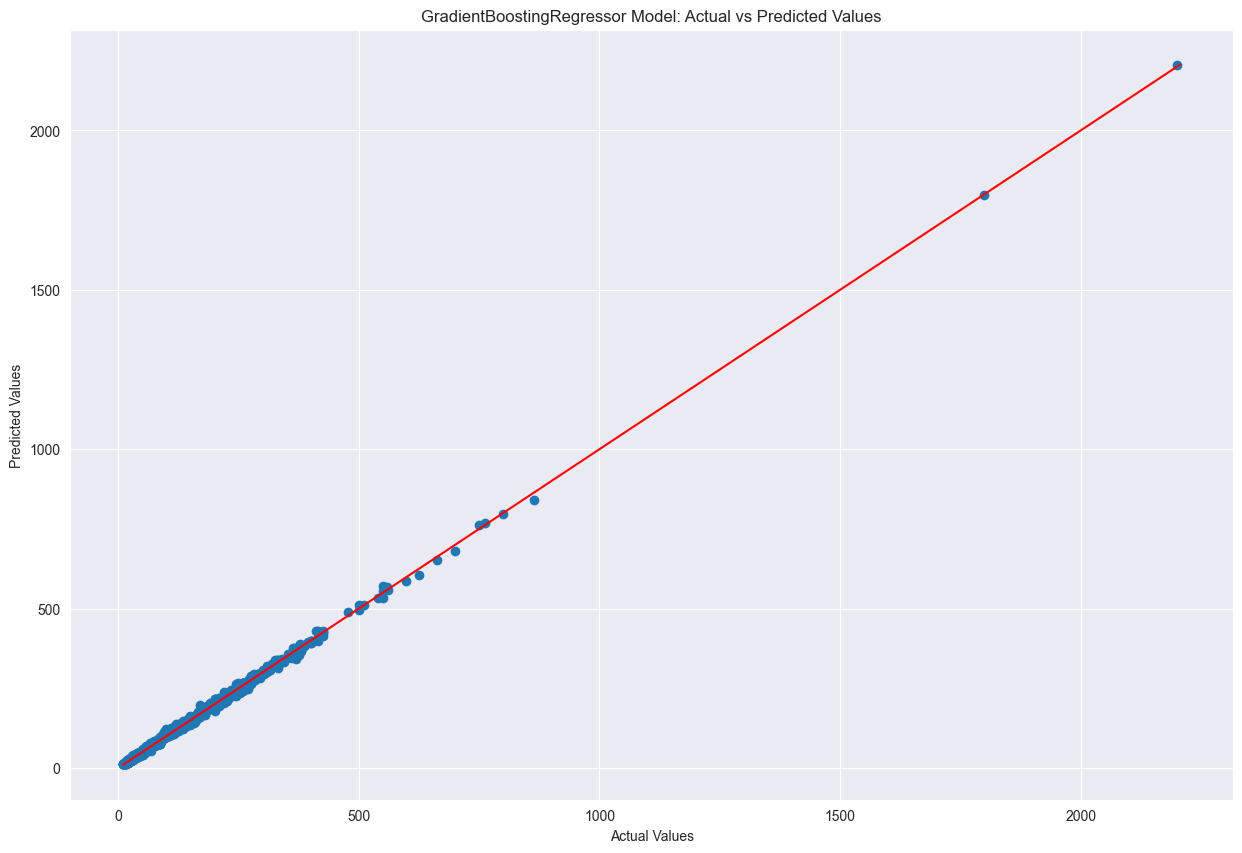

Model: LinearRegression, Mean Squared Error: 306.310244353394


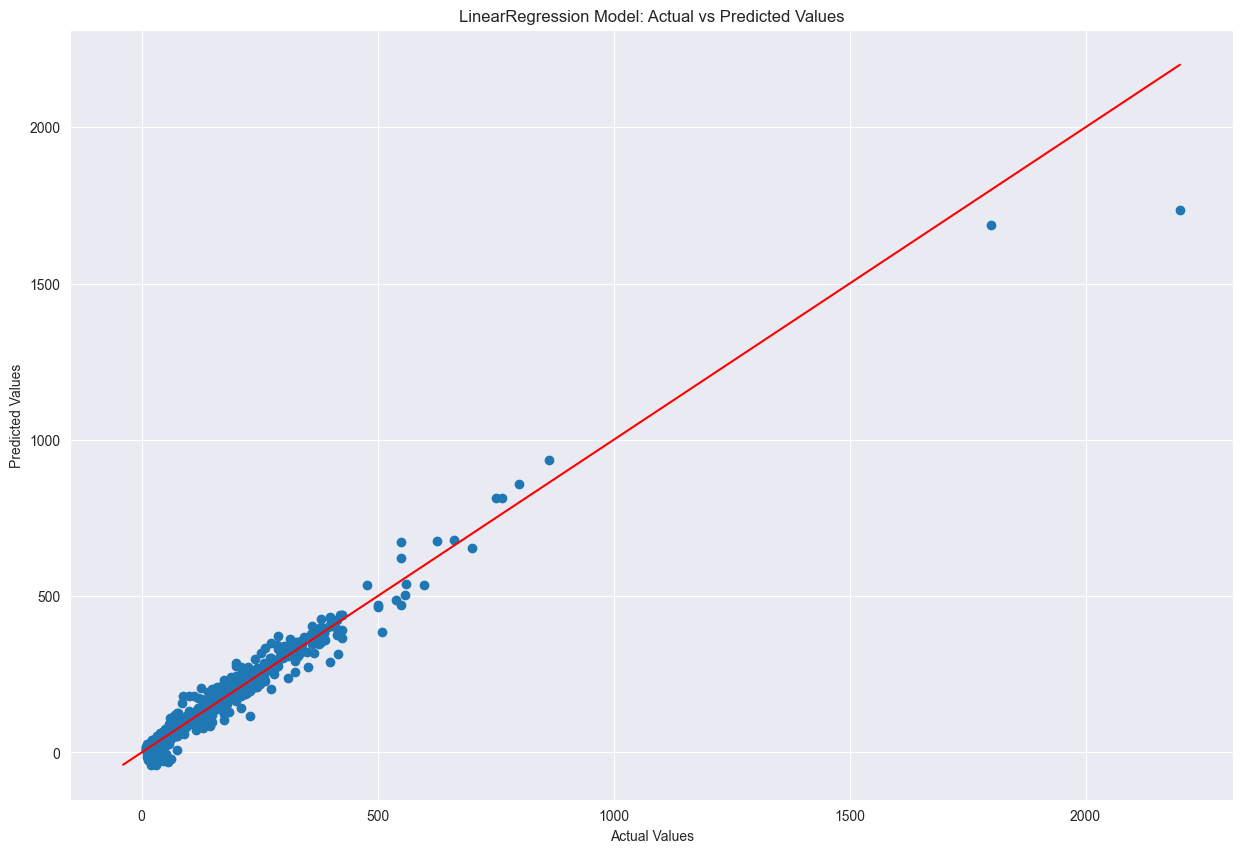

Model: DecisionTreeRegressor, Mean Squared Error: 353.4425470002131


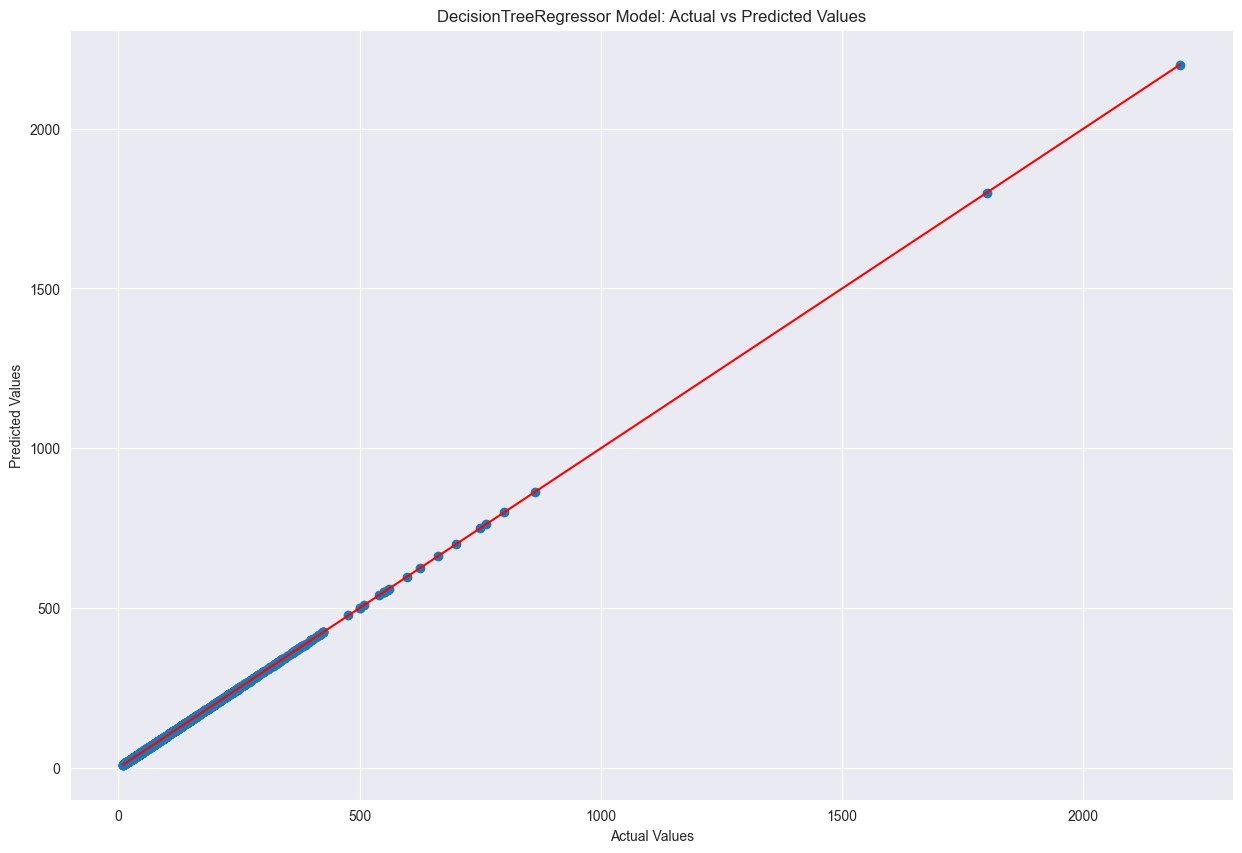

Model: SVR, Mean Squared Error: 3533.7492418321467


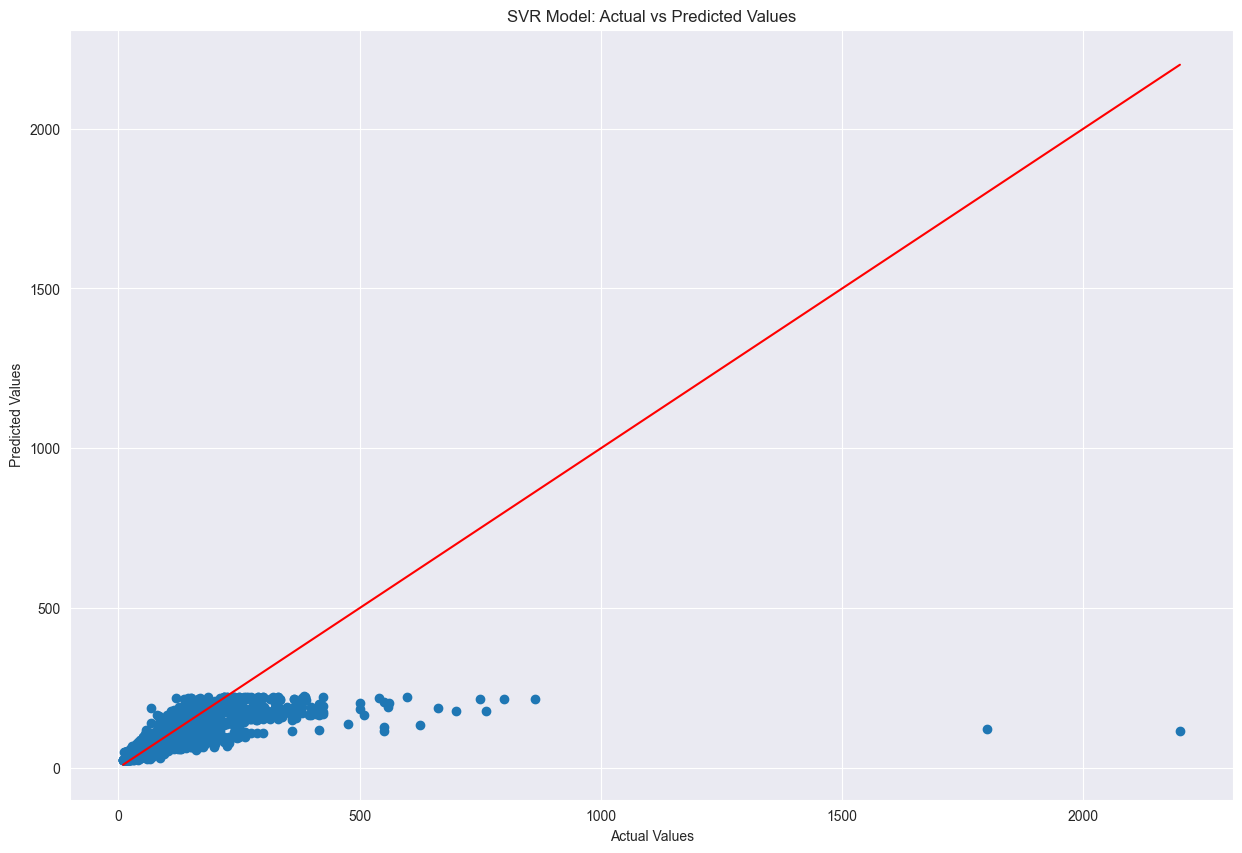

Model: Ridge, Mean Squared Error: 314.4471471565572


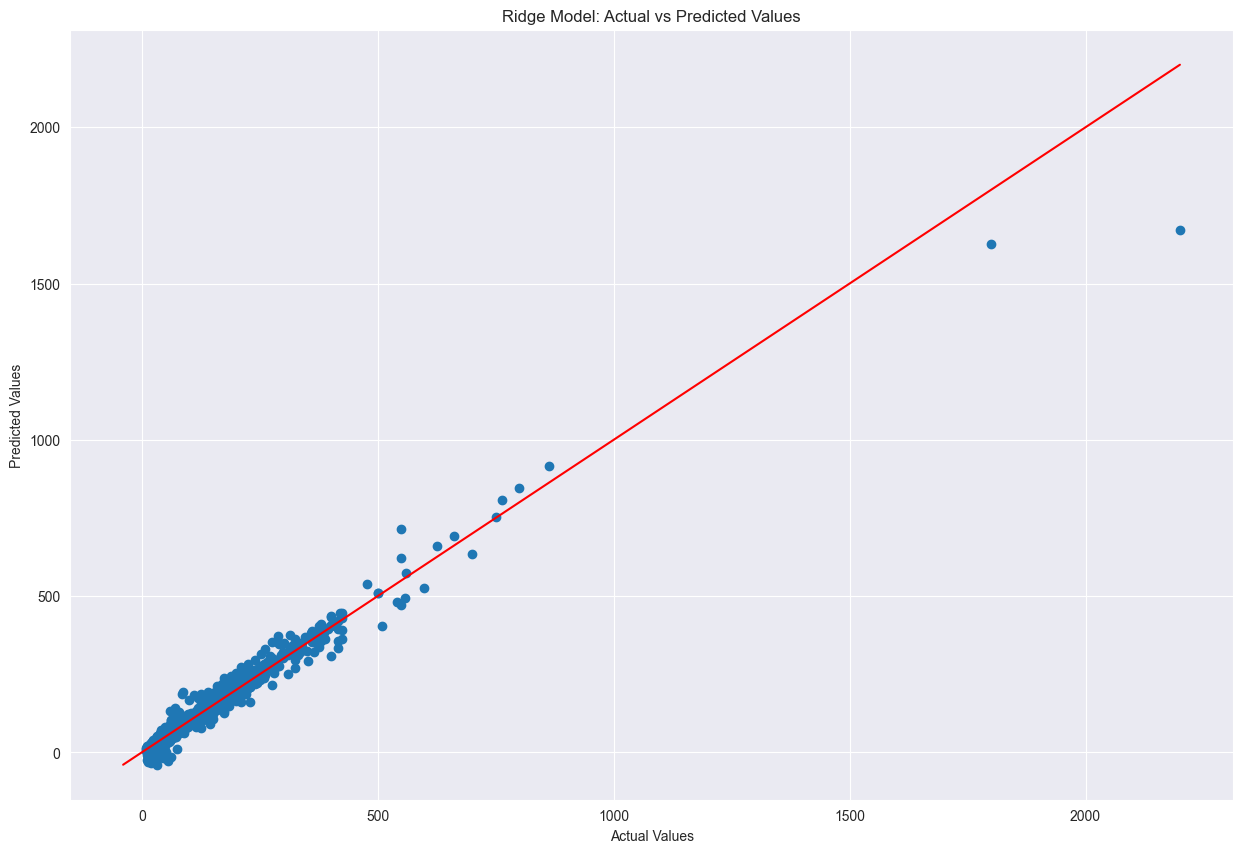

In [30]:
new_features_encoded = pd.get_dummies(new_features.data_train)
new_features_encoded.fillna(new_features_encoded.mean(), inplace=True)

for column in new_features_encoded.columns:
    if np.isinf(new_features_encoded[column]).any():
        max_val = new_features_encoded[~np.isinf(new_features_encoded[column])][column].max()
        new_features_encoded[column] = new_features_encoded[column].replace([np.inf, -np.inf], max_val)

# Now, 'new_features_encoded' is your DataFrame with encoded categorical variables
X = new_features_encoded.drop(['price'], axis=1)
y = new_features_encoded['price']

# Initialize the ModelSelection class with the data
ms = ModelSelection(X, y)

# Perform model selection
ms.select_model()

- Model: RandomForestRegressor, Mean Squared Error: 435.0566305168648
- Model: GradientBoostingRegressor, Mean Squared Error: 316.61492783470584
- Model: LinearRegression, Mean Squared Error: 306.310244353394
- Model: DecisionTreeRegressor, Mean Squared Error: 353.4425470002131
- Model: SVR, Mean Squared Error: 3533.7492418321467
- Model: Ridge, Mean Squared Error: 314.4471471565572